<code> 
<strong><font size="+3">CLUSTERING</font></strong>
In this Jupyter notebook, we cluster marine heatwave events in one ensemble member.
</code>
<code style="background:yellow;color:black">
Questions
    1. How do marine heatwave characteristics cluster in space and time?
        - Intensity, duration, and frequency of positive sea surface temperature anomalies
        - Probability of occurrence
    2. How important is ENSO variability in determining those clusters? (Not yet explored in this notebook)
    3. How unusual/extraordinary is the 2014/2015 North Pacific marine heatwave?
</code>


<code> 
<font size="+2">PREPROCESSING</font> 
</code>

<code> Import packages </code>

In [1]:
import xarray as xr; import numpy as np; import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import scipy

<code> Load data files </code>

In [2]:
filename = 'member0_events.nc'
# other ensemble members are saved like this '/glade/work/cassiacai/member1_events.nc'

member_ = xr.open_dataset(filename)

# How many heatwaves are in this particular ensemble member?
ending_val = len(np.unique(member_.labels))
print(ending_val-1)

370


In [3]:
# This cell uses ~ 150 GB of memory and takes ~ 3.5 minutes.
full_use_grids = []
full_SST_grids = []

for i in range(1,ending_val):  
    mhw_id = i
    mhw_event_rel = member_.where(member_.labels==mhw_id, drop=False)   # dimensions are (481, 192, 288) --> (time, lat, lon)
    x = mhw_event_rel.SSTA[:,:,:]
    full_SST_grids.append(x)
    no_nans_x = np.nan_to_num(x) # replace all nans with zeroes
    no_nans_x[no_nans_x != 0] = 1 # replace all SSTA values with 1 (for shape comparison)
    full_use_grids.append(no_nans_x)

In [4]:
# Check if the cell above is correct. It should be one less than ending_val.
print(len(full_use_grids) == ending_val-1)
print(len(full_SST_grids) == ending_val-1)

True
True


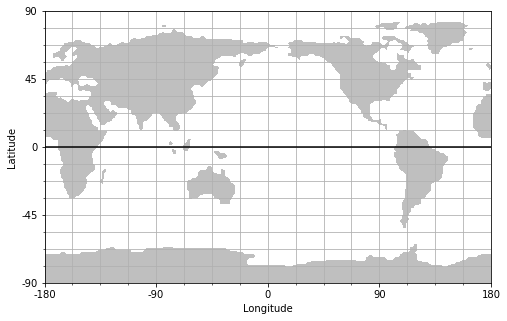

In [5]:
# landmask with relabeled axes
land_mask = np.load('SST_land.npy')
land_mask[land_mask > 0] = np.nan

fig, ax = plt.subplots(figsize=(8,5))
ax.contourf(land_mask, cmap='binary')
ax.minorticks_on()
ax.axhline(y=95.5, c='k', linestyle='-') # this is the equator line

ax.set_xticks([0, 71.75, 143.5, 215.25, 287]);ax.set_xticklabels([-180, -90, 0, 90, 180])
ax.set_yticks([0, 47.75, 95.5, 143.25, 191]);ax.set_yticklabels([-90, -45, 0, 45, 90])

ax.set_xlabel('Longitude'); ax.set_ylabel('Latitude')
ax.grid(which='both')

plt.show()

<code> 
<font size="+2">DENSITY ANALYSIS</font> 
</code>

In [6]:
month_indices = []
for i in range(0,12):
    month_indices.append(np.arange(i, 481, 12))

In [7]:
def month_indices_list(list_of_arrays):
    return np.sort(np.concatenate(list_of_arrays).ravel())

In [8]:
winter = set(month_indices_list([month_indices[0],month_indices[1],month_indices[11]]))  # Jan, Feb, Dec
spring = set(month_indices_list([month_indices[2],month_indices[3],month_indices[4]]))   # March, April, May
summer = set(month_indices_list([month_indices[5],month_indices[6],month_indices[7]]))   # June, July, Aug
fall = set(month_indices_list([month_indices[8],month_indices[9],month_indices[10]]))    # Sept, Oct, Nov

In [9]:
event_lengths = [] # saving the lengths of all MHWs
full__analysis_arrays = [] # all MHWs
density_analysis_arrays = [] # MHWs that last longer than X months
short_density_analysis_arrays = [] # MHWs that are X months long
nonzeroind_list = []
i_index= []

grids_to_use = full_use_grids

for i in range(0,len(grids_to_use)):
    sum_of_one = grids_to_use[i].sum(axis=(0))
    reshaped_sum_of_one = grids_to_use[i].reshape(481,192*288)
    a = reshaped_sum_of_one.sum(axis=(1))

    nonzeroind = np.nonzero(a) # starts at 1975-01-01 and ends on 2015-01-01
    nonzeroind_list.append(nonzeroind)
    event_len = np.nanmax(sum_of_one)
    event_lengths.append(event_len)

    if event_len > 1: # Can change this so we are looking at really long heatwaves
        density_analysis_arrays.append(sum_of_one)
        full__analysis_arrays.append(sum_of_one)
        i_index.append(i)
    else:
        short_density_analysis_arrays.append(sum_of_one)
        full__analysis_arrays.append(sum_of_one)

In [10]:
print(len(short_density_analysis_arrays), len(short_density_analysis_arrays) / len(full__analysis_arrays)*100)
print(len(density_analysis_arrays), len(density_analysis_arrays) / len(full__analysis_arrays)*100)
print(len(full__analysis_arrays))

154 41.62162162162162
216 58.37837837837838
370


In [11]:
def Extract(lst):
# Extract first element of each subarray in a list of arrays
    return [item[0][0] for item in lst]
    # return [item[0][-1] for item in lst] # return the last element of each subarray in a list of arrays

In [12]:
begin_indices = Extract(nonzeroind_list) # finds out when the heatwave occured (which months)

In [13]:
# Separating by seasons
winter_indices = []; winter_lens = []; winter_analysis_arrays = []
spring_indices = []; spring_lens = []; spring_analysis_arrays = []
summer_indices = []; summer_lens = []; summer_analysis_arrays = []
fall_indices = []; fall_lens = []; fall_analysis_arrays = []

for i in range(len(begin_indices)):
    if begin_indices[i] in winter:
        winter_indices.append(i)
        winter_lens.append(event_lengths[i])
        winter_analysis_arrays.append(full__analysis_arrays[i])
    elif begin_indices[i] in spring:
        spring_indices.append(i)
        spring_lens.append(event_lengths[i])
        spring_analysis_arrays.append(full__analysis_arrays[i])
    elif begin_indices[i] in summer:
        summer_indices.append(i)
        summer_lens.append(event_lengths[i])
        summer_analysis_arrays.append(full__analysis_arrays[i])
    elif begin_indices[i] in fall:
        fall_indices.append(i)
        fall_lens.append(event_lengths[i])
        fall_analysis_arrays.append(full__analysis_arrays[i])

print('winter: ',len(winter_analysis_arrays), len(winter_analysis_arrays) / len(full__analysis_arrays)*100)
print('spring: ',len(spring_analysis_arrays), len(spring_analysis_arrays) / len(full__analysis_arrays)*100)
print('summer: ',len(summer_analysis_arrays), len(summer_analysis_arrays) / len(full__analysis_arrays)*100)
print('fall:   ',len(fall_analysis_arrays), len(fall_analysis_arrays) / len(full__analysis_arrays)*100)

winter:  109 29.45945945945946
spring:  83 22.432432432432435
summer:  95 25.675675675675674
fall:    83 22.432432432432435


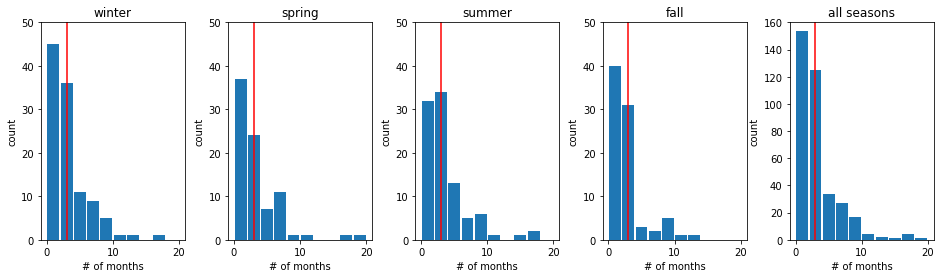

In [14]:
fig, axs = plt.subplots(1,5, figsize=(16, 4), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3, wspace=.3)
axs = axs.ravel()

groups = [winter_lens, spring_lens, summer_lens, fall_lens, event_lengths]
season_labels = ['winter', 'spring', 'summer', 'fall']
bins = [0,2,4,6,8,10,12,14,16,18,20]

for i in range(len(groups)-1):
    axs[i].hist(groups[i], bins=bins, rwidth=0.9)
    axs[i].set_ylim(0,50)
    axs[i].axvline(x=np.round(np.nanmean(groups[i])),c='red')
    axs[i].set_title(str(season_labels[i]))
    axs[i].set_ylabel('count')
    axs[i].set_xlabel('# of months')
axs[4].hist(event_lengths,bins=bins,rwidth=0.9)
axs[4].set_ylim(0,160)
axs[4].set_title('all seasons')
axs[4].axvline(x=np.round(np.nanmean(event_lengths)),c='red')
axs[4].set_ylabel('count')
axs[4].set_xlabel('# of months')
plt.show()

In [15]:
# Separating mhws longer than one month and those that last one month by season
length_of_mhws_winter = [np.nanmax(group) for group in winter_analysis_arrays]
length_of_mhws_spring = [np.nanmax(group) for group in spring_analysis_arrays]
length_of_mhws_summer = [np.nanmax(group) for group in summer_analysis_arrays]
length_of_mhws_fall = [np.nanmax(group) for group in fall_analysis_arrays]

# mhws longer than X month indices
long_month_dur = 1
indices_greater_than1_winter = [i for i,v in enumerate(length_of_mhws_winter) if v > long_month_dur]
indices_greater_than1_spring = [i for i,v in enumerate(length_of_mhws_spring) if v > long_month_dur]
indices_greater_than1_summer = [i for i,v in enumerate(length_of_mhws_summer) if v > long_month_dur]
indices_greater_than1_fall = [i for i,v in enumerate(length_of_mhws_fall) if v > long_month_dur]

# mhws that last X month
short_month_dur = 1
indices_1_winter = [i for i,v in enumerate(length_of_mhws_winter) if v == short_month_dur]
indices_1_spring = [i for i,v in enumerate(length_of_mhws_spring) if v == short_month_dur]
indices_1_summer = [i for i,v in enumerate(length_of_mhws_summer) if v == short_month_dur]
indices_1_fall = [i for i,v in enumerate(length_of_mhws_fall) if v == short_month_dur]

# saving as arrays (mhws longer than one month indices)
winter_long_arrays = [winter_analysis_arrays[x] for x in indices_greater_than1_winter]
spring_long_arrays = [spring_analysis_arrays[x] for x in indices_greater_than1_spring]
summer_long_arrays = [summer_analysis_arrays[x] for x in indices_greater_than1_summer]
fall_long_arrays = [fall_analysis_arrays[x] for x in indices_greater_than1_fall]

# saving as arrays (mhws that last one month)
winter_short_arrays = [winter_analysis_arrays[x] for x in indices_1_winter]
spring_short_arrays = [spring_analysis_arrays[x] for x in indices_1_spring]
summer_short_arrays = [summer_analysis_arrays[x] for x in indices_1_summer]
fall_short_arrays = [fall_analysis_arrays[x] for x in indices_1_fall]

In [16]:
print(np.nanmax(length_of_mhws_winter))
print(np.nanmax(length_of_mhws_spring))
print(np.nanmax(length_of_mhws_summer))
print(np.nanmax(length_of_mhws_fall))

16.0
20.0
21.0
12.0


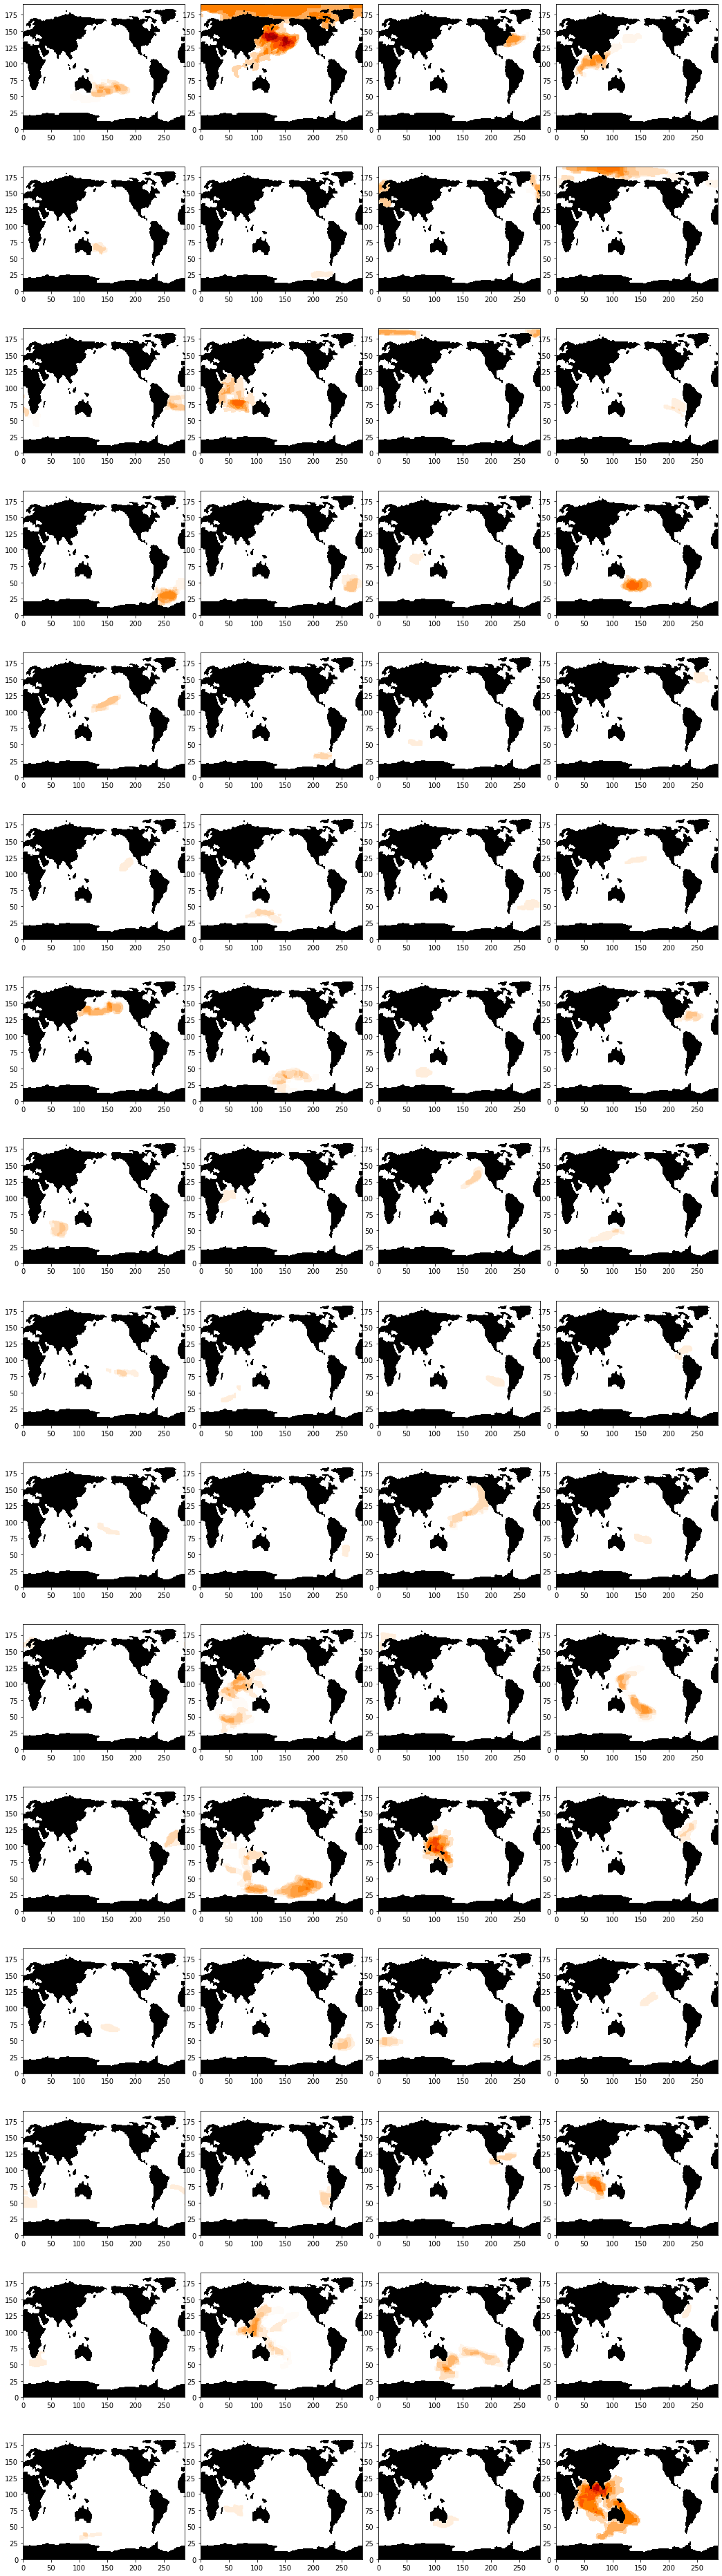

In [17]:
# Plotting all long mhws (long is defined as longer than 1 month long)
array_of_interest = winter_long_arrays #summer_long_arrays, fall_long_arrays, spring_long_arrays
fig, axs = plt.subplots(16,4, figsize=(18, 68), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3, wspace=.1)
axs = axs.ravel()

for i in range(len(array_of_interest)):
    axs[i].contourf(array_of_interest[i], cmap='gist_heat_r',vmin=1, vmax=25)
    axs[i].contourf(land_mask,cmap='binary_r',vmin=0)

In [18]:
print(len(indices_greater_than1_winter))
print(len(indices_greater_than1_spring))
print(len(indices_greater_than1_summer))
print(len(indices_greater_than1_fall))

64
46
63
43


In [19]:
all_shorts =  sum(winter_short_arrays) + sum(spring_short_arrays) + sum(summer_short_arrays) + sum(fall_short_arrays)

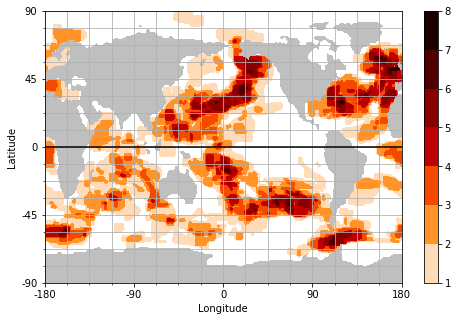

In [20]:
#Plotting all 1 month long heatwaves together
fig, ax = plt.subplots(figsize=(8,5))
im = ax.contourf(all_shorts, cmap='gist_heat_r', levels=[1,2,3,4,5,6,7,8])
fig.colorbar(im, orientation='vertical')
ax.contourf(land_mask, cmap='binary')
ax.minorticks_on()
ax.axhline(y=95.5, c='k', linestyle='-') # this is the equator line

ax.set_xticks([0, 71.75, 143.5, 215.25, 287]);ax.set_xticklabels([-180, -90, 0, 90, 180])
ax.set_yticks([0, 47.75, 95.5, 143.25, 191]);ax.set_yticklabels([-90, -45, 0, 45, 90])

ax.set_xlabel('Longitude'); ax.set_ylabel('Latitude')
ax.grid(which='both')

plt.show()

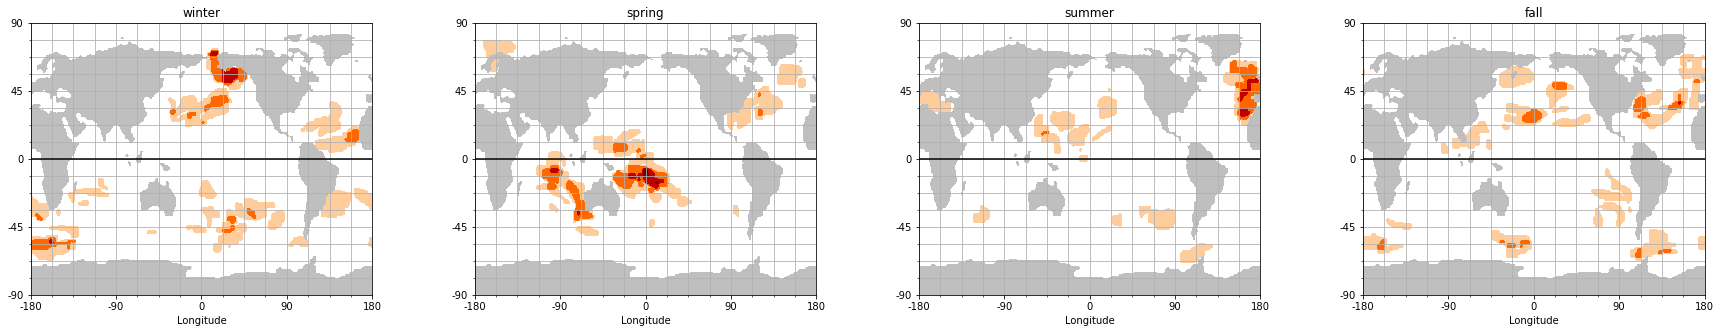

In [21]:
# This plot is missing a colorbar.
fig, axs = plt.subplots(1,4, figsize=(30, 5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3, wspace=.3)
axs = axs.ravel()

groups = [sum(winter_short_arrays), sum(spring_short_arrays), sum(summer_short_arrays), sum(fall_short_arrays)]
season_labels = ['winter', 'spring', 'summer', 'fall']
levels = [1,2,3,4,5,6]

for i in range(len(groups)):
    im = axs[i].contourf(groups[i], cmap='gist_heat_r',levels=levels)
    axs[i].set_title(str(season_labels[i]))
    axs[i].contourf(land_mask, cmap='binary')
    axs[i].axhline(y=95.5, c='k', linestyle='-') # this is the equator line
    axs[i].set_xticks([0, 71.75, 143.5, 215.25, 287]);axs[i].set_xticklabels([-180, -90, 0, 90, 180])
    axs[i].set_yticks([0, 47.75, 95.5, 143.25, 191]);axs[i].set_yticklabels([-90, -45, 0, 45, 90])
    axs[i].set_xlabel('Longitude'); ax.set_ylabel('Latitude')
    axs[i].minorticks_on(); axs[i].grid(which='both')

In [22]:
winter_long_arrays_copy = np.copy(winter_long_arrays)
spring_long_arrays_copy = np.copy(spring_long_arrays)
summer_long_arrays_copy = np.copy(summer_long_arrays)
fall_long_arrays_copy = np.copy(fall_long_arrays)

In [23]:
winter_long_arrays_ones = []
for i in range(len(winter_long_arrays_copy)):
    current_array = winter_long_arrays_copy[i]
    current_array[current_array > 0] = 1
    winter_long_arrays_ones.append(current_array)

spring_long_arrays_ones = []
for i in range(len(spring_long_arrays_copy)):
    current_array = spring_long_arrays_copy[i]
    current_array[current_array > 0] = 1
    spring_long_arrays_ones.append(current_array)

summer_long_arrays_ones = []
for i in range(len(summer_long_arrays_copy)):
    current_array = summer_long_arrays_copy[i]
    current_array[current_array > 0] = 1
    summer_long_arrays_ones.append(current_array)

fall_long_arrays_ones = []
for i in range(len(fall_long_arrays_copy)):
    current_array = fall_long_arrays_copy[i]
    current_array[current_array > 0] = 1
    fall_long_arrays_ones.append(current_array)

In [24]:
sum_winter_long_arrays_ones = sum(winter_long_arrays_ones)
sum_winter_long_arrays_ones[sum_winter_long_arrays_ones == 0] = np.nan

sum_spring_long_arrays_ones = sum(spring_long_arrays_ones)
sum_spring_long_arrays_ones[sum_spring_long_arrays_ones == 0] = np.nan

sum_summer_long_arrays_ones = sum(summer_long_arrays_ones)
sum_summer_long_arrays_ones[sum_summer_long_arrays_ones == 0] = np.nan

sum_fall_long_arrays_ones = sum(fall_long_arrays_ones)
sum_fall_long_arrays_ones[sum_fall_long_arrays_ones == 0] = np.nan

In [25]:
print(np.nanmax(sum_winter_long_arrays_ones))
print(np.nanmax(sum_spring_long_arrays_ones))
print(np.nanmax(sum_summer_long_arrays_ones))
print(np.nanmax(sum_fall_long_arrays_ones))

10.0
7.0
7.0
6.0


In [26]:
print(len(winter_long_arrays_ones))
print(len(spring_long_arrays_ones))
print(len(summer_long_arrays_ones))
print(len(fall_long_arrays_ones))

64
46
63
43


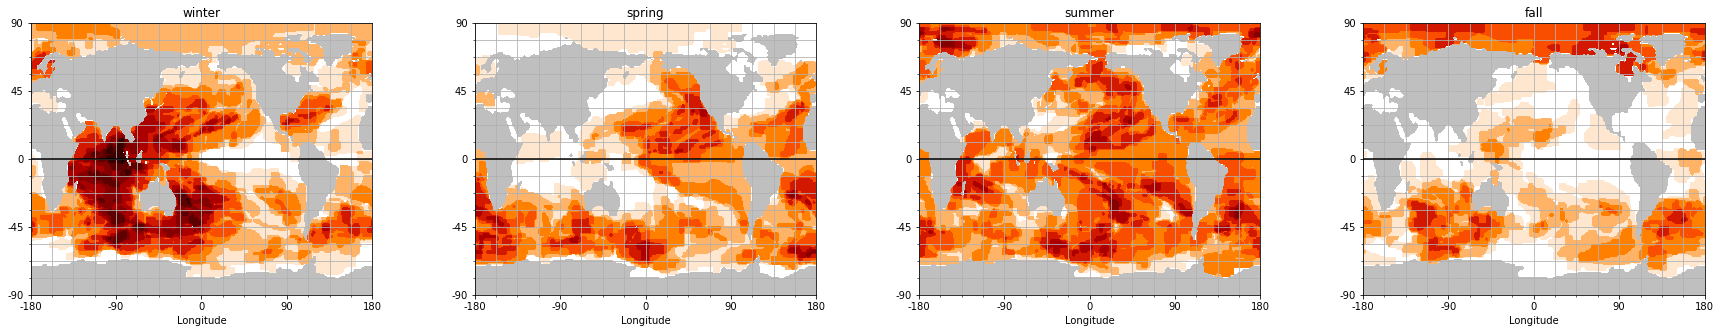

In [27]:
# This plot is missing a colorbar.
fig, axs = plt.subplots(1,4, figsize=(30, 5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3, wspace=.3)
axs = axs.ravel()

groups = [sum_winter_long_arrays_ones,sum_spring_long_arrays_ones,sum_summer_long_arrays_ones,sum_fall_long_arrays_ones]
season_labels = ['winter', 'spring', 'summer', 'fall']
levels = np.arange(0,11,1)

for i in range(len(groups)):
    im = axs[i].contourf(groups[i], cmap='gist_heat_r',levels=levels)
    axs[i].set_title(str(season_labels[i]))
    axs[i].contourf(land_mask, cmap='binary')
    axs[i].axhline(y=95.5, c='k', linestyle='-') # this is the equator line
    axs[i].set_xticks([0, 71.75, 143.5, 215.25, 287]);axs[i].set_xticklabels([-180, -90, 0, 90, 180])
    axs[i].set_yticks([0, 47.75, 95.5, 143.25, 191]);axs[i].set_yticklabels([-90, -45, 0, 45, 90])
    axs[i].set_xlabel('Longitude'); ax.set_ylabel('Latitude')
    axs[i].minorticks_on(); axs[i].grid(which='both')

In [28]:
sum_winter_long_arrays = sum(winter_long_arrays)
sum_winter_long_arrays[sum_winter_long_arrays == 0] = np.nan

sum_spring_long_arrays = sum(spring_long_arrays)
sum_spring_long_arrays[sum_spring_long_arrays == 0] = np.nan

sum_summer_long_arrays = sum(summer_long_arrays)
sum_summer_long_arrays[sum_summer_long_arrays == 0] = np.nan

sum_fall_long_arrays = sum(fall_long_arrays)
sum_fall_long_arrays[sum_fall_long_arrays == 0] = np.nan

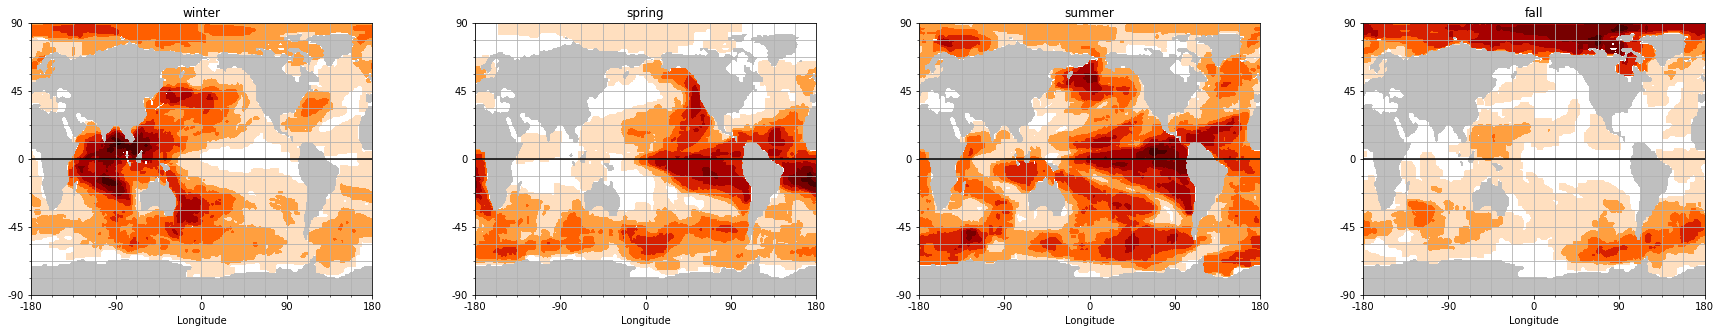

In [29]:
# This plot is missing a colorbar.
fig, axs = plt.subplots(1,4, figsize=(30, 5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3, wspace=.3)
axs = axs.ravel()

groups = [sum_winter_long_arrays,sum_spring_long_arrays,sum_summer_long_arrays,sum_fall_long_arrays]
season_labels = ['winter', 'spring', 'summer', 'fall']
levels = [0,5,10,15,20,25,30,35,40]

for i in range(len(groups)):
    im = axs[i].contourf(groups[i], cmap='gist_heat_r',levels=levels)
    axs[i].set_title(str(season_labels[i]))
    axs[i].contourf(land_mask, cmap='binary')
    axs[i].axhline(y=95.5, c='k', linestyle='-') # this is the equator line
    axs[i].set_xticks([0, 71.75, 143.5, 215.25, 287]);axs[i].set_xticklabels([-180, -90, 0, 90, 180])
    axs[i].set_yticks([0, 47.75, 95.5, 143.25, 191]);axs[i].set_yticklabels([-90, -45, 0, 45, 90])
    axs[i].set_xlabel('Longitude'); ax.set_ylabel('Latitude')
    axs[i].minorticks_on(); axs[i].grid(which='both')

<code> 
<font size="+2">SIMPLE SPATIAL CLUSTERING WITH EVENLY SPACED REGIONS</font> 
Simple location-based clustering is defined here as defining regions (subjective definition of regions). Marine heatwaves that have a footprint in those regions can then be grouped together. There is some overlap in the regions. The regions can be refined.
</code>

In [30]:
x_grid_size = 287/16; y_grid_size = 191/16

x_grid_bot = []; y_grid_bot = []

for i in range(16):
    x_grid_bot.append(i*x_grid_size)
    y_grid_bot.append(i*y_grid_size)

In [31]:
from itertools import product

all_combos = list(product(x_grid_bot, y_grid_bot))

In [32]:
def grid_loc(x_init, y_init, x_grid_len, y_grid_len):
    rows = np.arange(x_init, x_init+x_grid_len)
    columns = np.arange(y_init ,y_init+y_grid_len)
    loc_combinations = np.array([(int(i),int(j)) for i in rows for j in columns])
    loc_combo_set = set([tuple(x) for x in loc_combinations])
    return loc_combo_set

In [33]:
from matplotlib import patches # for the purpose of plotting

locpatches = []
loc_list = []
for i in range(len(all_combos)):
    locpatches.append(patches.Rectangle(all_combos[i], x_grid_size, y_grid_size, linewidth=1, edgecolor='r', facecolor='red',alpha=0.3))
    loc_list.append(grid_loc(all_combos[i][0], all_combos[i][1],x_grid_size,y_grid_size ))

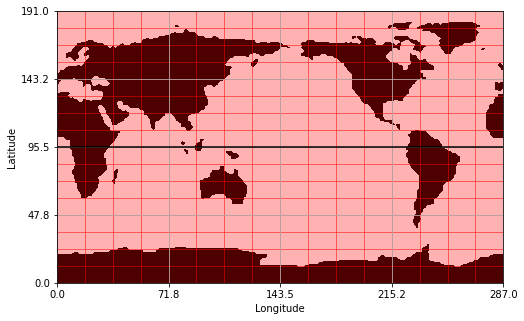

In [34]:
fig, ax = plt.subplots(figsize=(8,5))

ax.contourf(land_mask,cmap='binary_r',vmin=0)
ax.axhline(y=95.5, c='k', linestyle='-') # this is the equator line
ax.set_xticks([0, 71.75, 143.5, 215.25, 287])#;ax.set_xticklabels([-180, -90, 0, 90, 180])
ax.set_yticks([0, 47.75, 95.5, 143.25, 191])#;ax.set_yticklabels([-90, -45, 0, 45, 90])
ax.set_xlabel('Longitude'); ax.set_ylabel('Latitude')
ax.grid(which='both')
# Add the patch to the Axes
for i in range(len(locpatches)):
    ax.add_patch(locpatches[i])
plt.show()

In [35]:
array_seaon = winter_long_arrays_ones # requires user input to change season

inloc_full = []
for i in range(len(array_seaon)):
    loc_of_mhws = np.argwhere(array_seaon[i] == 1)
    loc_of_mhws_set = set([tuple(x) for x in loc_of_mhws])

    inloc_temp = []
    for j in range(len(loc_list)):
        inloc_temp.append(np.array([x for x in loc_list[j] & loc_of_mhws_set]))
    inloc_full.append(inloc_temp)

In [67]:
inloc_full_diff_reg = []
for i in range(len(loc_list)):
    inloc_full_diff_reg.append([item[i] for item in inloc_full])

lens_locs_list = []
for i in range(len(inloc_full_diff_reg)):
    lens_locs_list.append([len(l) for l in inloc_full_diff_reg[i]])

In [86]:
# let us remove the grids where there are no heatwaves ever
summinglistoflists = [sum(x) for x in lens_locs_list]
nonzeroind = np.nonzero(summinglistoflists)[0]
print(len(nonzeroind)) # there are the indices we will keep
kept_regions = [lens_locs_list[x] for x in nonzeroind]

146


<code> 
<font size="+2">SIMPLE SPATIAL CLUSTERING WITH UNEVENLY SPACED REGIONS</font> 
</code>

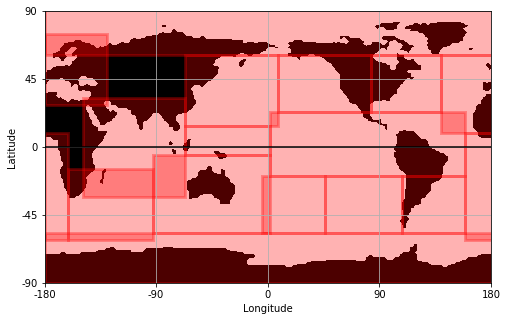

In [78]:
# original way of making patches
fig, ax = plt.subplots(figsize=(8,5))

# Display the image
ax.contourf(land_mask,cmap='binary_r',vmin=0)
ax.axhline(y=95.5, c='k', linestyle='-') # this is the equator line
ax.set_xticks([0, 71.75, 143.5, 215.25, 287]);ax.set_xticklabels([-180, -90, 0, 90, 180])
ax.set_yticks([0, 47.75, 95.5, 143.25, 191]);ax.set_yticklabels([-90, -45, 0, 45, 90])
ax.set_xlabel('Longitude'); ax.set_ylabel('Latitude')
ax.grid(which='both')

# Create a Rectangle patch
loc1 = patches.Rectangle((0, 160), 288-0, 192-160, linewidth=3, edgecolor='r', facecolor='red',alpha=0.3) 
loc2 = patches.Rectangle((0, 125), 40-0, 175-125, linewidth=3, edgecolor='r', facecolor='red',alpha=0.3) 
loc3 = patches.Rectangle((90, 110), 150-90, 160-110, linewidth=3, edgecolor='r', facecolor='red',alpha=0.3) 
loc4 = patches.Rectangle((150, 120), 210-150, 160-120, linewidth=3, edgecolor='r', facecolor='red',alpha=0.3) 
loc5 = patches.Rectangle((210, 120), 255-210, 160-120, linewidth=3, edgecolor='r', facecolor='red',alpha=0.3) 
loc6= patches.Rectangle((255, 105), 288-255, 160-105, linewidth=3, edgecolor='r', facecolor='red',alpha=0.3) 
loc7= patches.Rectangle((25, 60), 90-25, 130-60, linewidth=3, edgecolor='r', facecolor='red',alpha=0.3) 
loc8= patches.Rectangle((0, 30), 15-0, 105-30, linewidth=3, edgecolor='r', facecolor='red',alpha=0.3)  # patch 8a
loc9= patches.Rectangle((15, 30), 70-15, 80-30, linewidth=3, edgecolor='r', facecolor='red',alpha=0.3) 
loc10= patches.Rectangle((0, 0), 288-0, 35-0, linewidth=3, edgecolor='r', facecolor='red',alpha=0.3) 
loc11= patches.Rectangle((90, 90), 145-90, 110-90, linewidth=3, edgecolor='r', facecolor='red',alpha=0.3) 
loc12= patches.Rectangle((70, 35), 145-70, 90-35, linewidth=3, edgecolor='r', facecolor='red',alpha=0.3) 
loc13= patches.Rectangle((145, 75), 270-145, 120-75, linewidth=3, edgecolor='r', facecolor='red',alpha=0.3) 
loc14= patches.Rectangle((140, 35), 180-140, 180-140, linewidth=3, edgecolor='r', facecolor='red',alpha=0.3) 
loc15= patches.Rectangle((180, 35), 230-180, 75-35, linewidth=3, edgecolor='r', facecolor='red',alpha=0.3) 
loc16= patches.Rectangle((230, 35), 270-230, 75-35, linewidth=3, edgecolor='r', facecolor='red',alpha=0.3) 
loc17= patches.Rectangle((270, 30), 288-270, 105-30, linewidth=3, edgecolor='r', facecolor='red',alpha=0.3)  # patch 8b

# Add the patch to the Axes
ax.add_patch(loc1); ax.add_patch(loc2); ax.add_patch(loc3); ax.add_patch(loc4)
ax.add_patch(loc5); ax.add_patch(loc6); ax.add_patch(loc7); ax.add_patch(loc8)
ax.add_patch(loc9); ax.add_patch(loc10); ax.add_patch(loc11); ax.add_patch(loc12)
ax.add_patch(loc13); ax.add_patch(loc14); ax.add_patch(loc15); ax.add_patch(loc16); ax.add_patch(loc17)

plt.show()

In [79]:
# Location 1: 160: 192, 0:288 # Northern polar region
rows = np.arange(160,192); columns = np.arange(0,288) 
loc_1_combinations = np.array([(i,j) for i in rows for j in columns])
loc_1_combo_set = set([tuple(x) for x in loc_1_combinations])

# Location 2: 125:175, 0:40 # this is the European region
rows = np.arange(125,175); columns = np.arange(0,40)
loc_2_combinations = np.array([(i,j) for i in rows for j in columns])
loc_2_combo_set = set([tuple(x) for x in loc_2_combinations])

# Location 3: 110:160, 90:150 # this is off of Asia
rows = np.arange(110,160); columns = np.arange(90,150)
loc_3_combinations = np.array([(i,j) for i in rows for j in columns])
loc_3_combo_set = set([tuple(x) for x in loc_3_combinations])

# Location 4: 125:160, 150:210 # this is Northwest Pacific
rows = np.arange(125,160); columns = np.arange(150,210)
loc_4_combinations = np.array([(i,j) for i in rows for j in columns])
loc_4_combo_set = set([tuple(x) for x in loc_4_combinations])

# Location 5: 120:160, 210:255 # this is the Northwest Atlantic
rows = np.arange(120,160); columns = np.arange(210,255)
loc_5_combinations = np.array([(i,j) for i in rows for j in columns])
loc_5_combo_set = set([tuple(x) for x in loc_5_combinations])

# Location 6: 105:160, 255:288
rows = np.arange(105,160); columns = np.arange(255,288)
loc_6_combinations = np.array([(i,j) for i in rows for j in columns])
loc_6_combo_set = set([tuple(x) for x in loc_6_combinations])

# Location 7: 60:130, 25:90 # this is off south Asia
rows = np.arange(60,130); columns = np.arange(25,90)
loc_7_combinations = np.array([(i,j) for i in rows for j in columns])
loc_7_combo_set = set([tuple(x) for x in loc_7_combinations])

# Location 8: 30:105, 0:15 and 30:105, 270:288
rows = np.arange(30,105); columns = np.arange(0,15)
loc_8a_combinations = np.array([(i,j) for i in rows for j in columns])
loc_8a_combo_set = set([tuple(x) for x in loc_8a_combinations])

rows = np.arange(30,105); columns = np.arange(270,288)
loc_8b_combinations = np.array([(i,j) for i in rows for j in columns])
loc_8b_combo_set = set([tuple(x) for x in loc_8b_combinations])

# Location 9: 30:80, 15:70
rows = np.arange(30,80); columns = np.arange(15,70)
loc_9_combinations = np.array([(i,j) for i in rows for j in columns])
loc_9_combo_set = set([tuple(x) for x in loc_9_combinations])

# Location 10: 0:35, 0:288 # this is the southern polar region
rows = np.arange(0,35); columns = np.arange(0,288)
loc_10_combinations = np.array([(i,j) for i in rows for j in columns])
loc_10_combo_set = set([tuple(x) for x in loc_10_combinations])

# Location 11: 90:110, 95:145
rows = np.arange(90,110); columns = np.arange(95,145)
loc_11_combinations = np.array([(i,j) for i in rows for j in columns])
loc_11_combo_set = set([tuple(x) for x in loc_11_combinations])

# Location 12: 35:90, 70:145 # this is Australia
rows = np.arange(35,90); columns = np.arange(70,145)
loc_12_combinations = np.array([(i,j) for i in rows for j in columns])
loc_12_combo_set = set([tuple(x) for x in loc_12_combinations])

# Location 13: 75:120, 145:270
rows = np.arange(75,120); columns = np.arange(145,270)
loc_13_combinations = np.array([(i,j) for i in rows for j in columns])
loc_13_combo_set = set([tuple(x) for x in loc_13_combinations])

# Location 14: 35:75, 140:180
rows = np.arange(35,75); columns = np.arange(140,180)
loc_14_combinations = np.array([(i,j) for i in rows for j in columns])
loc_14_combo_set = set([tuple(x) for x in loc_14_combinations])

# Location 15: 35:75, 180:230
rows = np.arange(35,75); columns = np.arange(180,230)
loc_15_combinations = np.array([(i,j) for i in rows for j in columns])
loc_15_combo_set = set([tuple(x) for x in loc_15_combinations])

# Location 16: 35:75, 230:270
rows = np.arange(35,75); columns = np.arange(230,270)
loc_16_combinations = np.array([(i,j) for i in rows for j in columns])
loc_16_combo_set = set([tuple(x) for x in loc_16_combinations])

In [80]:
array_in_question = winter_long_arrays_ones[1]
solutions = np.argwhere(array_in_question == 1)
bset = set([tuple(x) for x in solutions])

In [81]:
loc1_list = []; loc2_list = []; loc3_list = []; loc4_list = []
loc5_list = []; loc6_list = []; loc7_list = []; loc8a_list = []; loc8b_list = []
loc9_list = []; loc10_list = []; loc11_list = []; loc12_list = []
loc13_list = []; loc14_list = []; loc15_list = []; loc16_list = []

array_seaon = winter_long_arrays_ones # requires user input to change season

for i in range(len(array_seaon)):
    loc_of_mhws = np.argwhere(array_seaon[i] == 1)
    loc_of_mhws_set = set([tuple(x) for x in loc_of_mhws])
    
    in_loc1 = np.array([x for x in loc_1_combo_set & loc_of_mhws_set]); loc1_list.append(in_loc1)
    in_loc2 = np.array([x for x in loc_2_combo_set & loc_of_mhws_set]); loc2_list.append(in_loc2)
    in_loc3 = np.array([x for x in loc_3_combo_set & loc_of_mhws_set]); loc3_list.append(in_loc3)
    in_loc4 = np.array([x for x in loc_4_combo_set & loc_of_mhws_set]); loc4_list.append(in_loc4)
    in_loc5 = np.array([x for x in loc_5_combo_set & loc_of_mhws_set]); loc5_list.append(in_loc5)
    in_loc6 = np.array([x for x in loc_6_combo_set & loc_of_mhws_set]); loc6_list.append(in_loc6)
    in_loc7 = np.array([x for x in loc_7_combo_set & loc_of_mhws_set]); loc7_list.append(in_loc7)
    in_loc8a = np.array([x for x in loc_8a_combo_set & loc_of_mhws_set]); loc8a_list.append(in_loc8a)
    in_loc8b = np.array([x for x in loc_8b_combo_set & loc_of_mhws_set]); loc8b_list.append(in_loc8b)
    in_loc9 = np.array([x for x in loc_9_combo_set & loc_of_mhws_set]); loc9_list.append(in_loc9)
    in_loc10 = np.array([x for x in loc_10_combo_set & loc_of_mhws_set]); loc10_list.append(in_loc10)
    in_loc11 = np.array([x for x in loc_11_combo_set & loc_of_mhws_set]); loc11_list.append(in_loc11)
    in_loc12 = np.array([x for x in loc_12_combo_set & loc_of_mhws_set]); loc12_list.append(in_loc12)
    in_loc13 = np.array([x for x in loc_13_combo_set & loc_of_mhws_set]); loc13_list.append(in_loc13)
    in_loc14 = np.array([x for x in loc_14_combo_set & loc_of_mhws_set]); loc14_list.append(in_loc14)
    in_loc15 = np.array([x for x in loc_15_combo_set & loc_of_mhws_set]); loc15_list.append(in_loc15)
    in_loc16 = np.array([x for x in loc_16_combo_set & loc_of_mhws_set]); loc16_list.append(in_loc16)

In [82]:
loc8_list = loc8a_list + loc8b_list

In [83]:
lens_loc1_list = [len(l) for l in loc1_list] # np.asarray([len(l) for l in loc1_list])
lens_loc2_list = [len(l) for l in loc2_list] # np.asarray([len(l) for l in loc2_list])
lens_loc3_list = [len(l) for l in loc3_list] # np.asarray([len(l) for l in loc3_list])
lens_loc4_list = [len(l) for l in loc4_list] # np.asarray([len(l) for l in loc4_list])
lens_loc5_list = [len(l) for l in loc5_list] # np.asarray([len(l) for l in loc5_list])
lens_loc6_list = [len(l) for l in loc6_list] # np.asarray([len(l) for l in loc6_list])
lens_loc7_list = [len(l) for l in loc7_list] # np.asarray([len(l) for l in loc7_list])
lens_loc8_list = [len(l) for l in loc8_list] # np.asarray([len(l) for l in loc8_list])
lens_loc9_list = [len(l) for l in loc9_list] # np.asarray([len(l) for l in loc9_list])
lens_loc10_list = [len(l) for l in loc10_list] # np.asarray([len(l) for l in loc10_list])
lens_loc11_list = [len(l) for l in loc11_list] # np.asarray([len(l) for l in loc11_list])
lens_loc12_list = [len(l) for l in loc12_list] # np.asarray([len(l) for l in loc12_list])
lens_loc13_list = [len(l) for l in loc13_list]# np.asarray([len(l) for l in loc13_list])
lens_loc14_list = [len(l) for l in loc14_list] # np.asarray([len(l) for l in loc14_list])
lens_loc15_list = [len(l) for l in loc15_list] # np.asarray([len(l) for l in loc15_list])
lens_loc16_list = [len(l) for l in loc16_list] # np.asarray([len(l) for l in loc16_list])

In [84]:
df_locations = pd.DataFrame(list(zip(lens_loc1_list, lens_loc2_list, lens_loc3_list, lens_loc4_list,
                          lens_loc5_list, lens_loc6_list, lens_loc7_list, lens_loc8_list,
                          lens_loc9_list, lens_loc10_list, lens_loc11_list, lens_loc12_list,
                          lens_loc13_list, lens_loc14_list, lens_loc15_list, lens_loc16_list)),
               columns =['loc1', 'loc2', 'loc3', 'loc4',
                        'loc5', 'loc6', 'loc7', 'loc8', 
                        'loc9', 'loc10', 'loc11', 'loc12',
                        'loc13', 'loc14', 'loc15', 'loc16'])

In [85]:
lens_loc1_list

[0,
 5807,
 0,
 0,
 0,
 0,
 342,
 4321,
 0,
 0,
 1207,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 79,
 0,
 0,
 0,
 0,
 70,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 170,
 0,
 562,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [42]:
# add a column to save the mhw indices
# df_locations['index_col'] = df_locations.index
loc1_perc = df_locations['loc1'] / len(loc_1_combinations)*100
loc2_perc = df_locations['loc2'] / len(loc_2_combinations)*100
loc3_perc = df_locations['loc3'] / len(loc_3_combinations)*100
loc4_perc = df_locations['loc4'] / len(loc_4_combinations)*100
loc5_perc = df_locations['loc5'] / len(loc_5_combinations)*100
loc6_perc = df_locations['loc6'] / len(loc_6_combinations)*100
loc7_perc = df_locations['loc7'] / len(loc_7_combinations)*100
loc8_perc = df_locations['loc8'] / (len(loc_8a_combinations)+len(loc_8b_combinations))*100
loc9_perc = df_locations['loc9'] / len(loc_9_combinations)*100
loc10_perc = df_locations['loc10'] / len(loc_10_combinations)*100
loc11_perc = df_locations['loc11'] / len(loc_11_combinations)*100
loc12_perc = df_locations['loc12'] / len(loc_12_combinations)*100
loc13_perc = df_locations['loc13'] / len(loc_13_combinations)*100
loc14_perc = df_locations['loc14'] / len(loc_14_combinations)*100
loc15_perc = df_locations['loc15'] / len(loc_15_combinations)*100
loc16_perc = df_locations['loc16'] / len(loc_16_combinations)*100

In [43]:
df_locations_perc = pd.DataFrame(list(zip(loc1_perc, loc2_perc, loc3_perc, loc4_perc,
                          loc5_perc, loc6_perc, loc7_perc, loc8_perc,
                          loc9_perc, loc10_perc, loc11_perc, loc12_perc,
                          loc13_perc, loc14_perc, loc15_perc, loc16_perc)),
               columns =['loc1', 'loc2', 'loc3', 'loc4',
                        'loc5', 'loc6', 'loc7', 'loc8', 
                        'loc9', 'loc10', 'loc11', 'loc12',
                        'loc13', 'loc14', 'loc15', 'loc16'])

In [44]:
df_locations['non_zero'] = df_locations.apply(np.flatnonzero, axis=1) +1
df_locations_perc['non_zero'] = df_locations_perc.apply(np.flatnonzero, axis=1) +1

In [45]:
df_locations_perc

,loc1,loc2,loc3,loc4,loc5,loc6,loc7,loc8,loc9,loc10,loc11,loc12,loc13,loc14,loc15,loc16,non_zero
0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,28.678788,0.497778,53.5000,7.0,0.0,"[12, 13, 14, 15]"
1,63.009983,17.05,78.866667,29.476190,4.888889,0.661157,39.296703,0.0,14.727273,0.000000,44.2,8.993939,0.764444,0.0000,0.0,0.0,"[1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13]"
2,0.000000,0.00,0.000000,0.000000,32.111111,7.493113,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0000,0.0,0.0,"[5, 6]"
3,0.000000,0.00,32.033333,8.190476,0.000000,0.000000,33.538462,0.0,0.690909,0.000000,4.2,2.060606,0.000000,0.0000,0.0,0.0,"[3, 4, 7, 9, 11, 12]"
4,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,12.363636,0.000000,11.5000,0.0,0.0,"[12, 14]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0.000000,0.00,0.000000,0.000000,31.277778,2.809917,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.551111,0.0000,0.0,0.0,"[5, 6, 13]"
60,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,3.224206,0.0,17.624242,0.000000,6.5625,0.0,0.0,"[10, 12, 14]"
61,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,15.076923,0.0,10.436364,0.000000,0.0,5.600000,0.000000,0.0000,0.0,0.0,"[7, 9, 12]"
62,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,20.266667,0.000000,4.1875,0.0,0.0,"[12, 14]"


In [46]:
weighting_list = []; region_num_list = []

dataframe_used = df_locations
for i in range(len(dataframe_used)):
    weighting_list_sublist = []; region_num_list_sublist = []
    for j in df_locations_perc['non_zero'][i]:
        weighting_list_sublist.append(dataframe_used.loc[i].iloc[j-1])
        region_num_list_sublist.append(j)
    weighting_list.append(weighting_list_sublist)
    region_num_list.append(region_num_list_sublist)

In [47]:
sortedRegions_list = []; sorted_weighting_list = []
for i in range(len(weighting_list)):
    inds = np.array(weighting_list[i])
    inds = np.argsort(-inds)
    ind_new = -np.sort(-np.asarray((weighting_list[i])))
    sorted_weighting_list.append(ind_new)
    sortedRegions = np.array(region_num_list[i])[inds]
    sortedRegions_list.append(sortedRegions)

In [48]:
print(weighting_list[0])
print(region_num_list[0])
print(sorted_weighting_list[0])
print(sortedRegions_list[0])

[1183, 28, 856, 140]
[12, 13, 14, 15]
[1183  856  140   28]
[12 14 15 13]


<code> 
<strong>Cluster sequences of data with different lengths</strong>
Orignially sourced from https://stats.stackexchange.com/questions/127484/cluster-sequences-of-data-with-different-length
One way to do it (among many other ways) is to treat the element of your sequence as a word. In other words, if your assume your list is a sentence, then you can extract ngrams.
</code>

In [49]:
import nltk # Natural Language Toolkit https://www.nltk.org/index.html 
from nltk import ngrams
from sklearn.feature_extraction.text import CountVectorizer # Convert a collection of text documents to a matrix of token counts
from sklearn.cluster import KMeans
from sklearn import metrics

In [50]:
bb = list()
for i in range(len(sortedRegions_list)):
    # added the x, because seems CountVectorizer neglects single numbers/letters
    bb.append(str(','.join(str(e) for e in ['x' + str(e) for e in sortedRegions_list[i]])))

In [51]:
vectorizer = CountVectorizer() # implementation produces a sparse representation of the counts using scipy.sparse.csr_matrix
X = vectorizer.fit_transform(bb)
print(X.toarray())
print(vectorizer.get_feature_names_out())

[[0 0 0 ... 0 0 0]
 [1 0 1 ... 1 0 1]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 1]
 [0 0 0 ... 0 0 0]
 [0 1 1 ... 1 0 1]]
['x1' 'x10' 'x11' 'x12' 'x13' 'x14' 'x15' 'x16' 'x2' 'x3' 'x4' 'x5' 'x6'
 'x7' 'x8' 'x9']


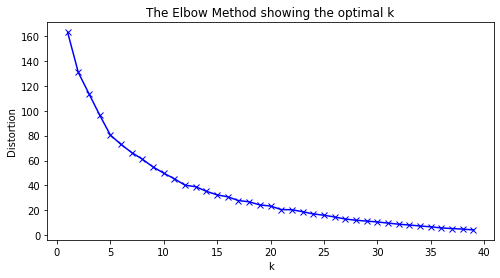

In [52]:
# we now have a feature matrix and can now do clustering, for example kmeans
distortions = []
K = range(1,40)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)
# Plot of the elbow method results
plt.figure(figsize=(8,4))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k'); plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [53]:
kmeans = KMeans(n_clusters=16, random_state=0).fit(X)
# print(kmeans.labels_)
centroids = kmeans.cluster_centers_

In [54]:
clustered_heatwaves = []
for i in np.unique(kmeans.labels_):
    clustered_heatwaves.append(np.where(np.asarray(kmeans.labels_) == i))
# comments: seems to be working fine. I have set 16 clusters.
# From the elbow plot, it seems that we could go up to 20 or even 25.

In [55]:
clustered_heatwaves

[(array([ 2, 19, 27, 35, 44, 47, 54, 59]),),
 (array([ 4, 15, 25, 39, 60, 62]),),
 (array([ 5, 17, 37, 49]),),
 (array([10, 24]),),
 (array([16, 23, 38, 43, 46, 57]),),
 (array([21, 26, 31]),),
 (array([ 8, 50, 52, 56]),),
 (array([ 0, 32, 36, 48, 58]),),
 (array([ 3, 41, 63]),),
 (array([ 9, 14, 18, 28, 29, 33, 55, 61]),),
 (array([ 6,  7, 40, 42]),),
 (array([12, 13, 22]),),
 (array([11, 34, 53]),),
 (array([1]),),
 (array([20, 30, 51]),),
 (array([45]),)]

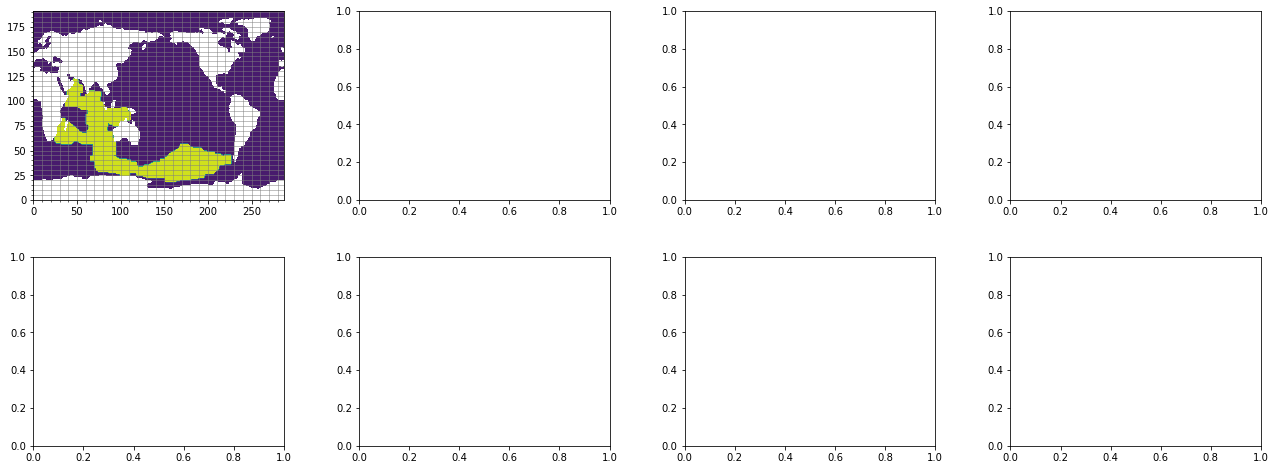

In [72]:
# we will now plot a subset of heatwaves in each category
fig, axs = plt.subplots(2,4, figsize=(22, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3, wspace=.3)
axs = axs.ravel()

which_group = 15
for i in range(len(np.asarray(clustered_heatwaves[which_group][0]))):
    axs[i].contourf(winter_long_arrays_ones[clustered_heatwaves[which_group][0][i]])
    axs[i].contourf(land_mask,cmap='binary',vmin=0)
    axs[i].minorticks_on()
    axs[i].grid(which='both', linestyle='-', linewidth='0.5', color='gray')

<code> 
<strong>Modifying the method above to cluster sequences of data with different lengths </strong>'
Notes: This does not work as I expected. I expected the clustering to be more refined. 
Question: Maybe ask Valentina?
    
Note: clustering 
</code>

In [ ]:
def NumToStr(numbers, alpha):
    ret = []
    for num in numbers:
        try:
            ret.append(alpha[num])
        except:
            pass
    return ret

In [ ]:
alpha = "abcdefghijklmnopkrstuvwxyz"
regions_as_letters = [NumToStr(group, alpha) for group in sortedRegions_list]

In [ ]:
weight_let = []
for i in range(len(regions_as_letters)):
    weight_let_temp = []
    for j in range(len(regions_as_letters[i])):
        weight_let_temp.append(str(sorted_weighting_list[i][j])+str(regions_as_letters[i][j]))
    weight_let.append(weight_let_temp)

weight_let_list = []
for i in range(len(weight_let)):
    s = ','.join(weight_let[i])
    weight_let_list.append(str(s))

In [ ]:
vectorizer = CountVectorizer() # same method as above
X = vectorizer.fit_transform(weight_let_list)
# print(X.toarray())
# print(vectorizer.get_feature_names_out())

In [ ]:
# we now have a feature matrix and can now do clustering, for example kmeans
distortions = []
K = range(1,40)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)
# Plot of the elbow method results
plt.figure(figsize=(8,4))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k'); plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(X)
# print(kmeans.labels_)
centroids = kmeans.cluster_centers_

In [ ]:
clustered_heatwaves = []
for i in np.unique(kmeans.labels_):
    clustered_heatwaves.append(np.where(np.asarray(kmeans.labels_) == i))

In [ ]:
clustered_heatwaves
# not quite what I would like because the biggest group is the first one.
# When we check as subset of heatwaves in this category, these heatwaves do not appear to be very similar.

In [ ]:
# we will now plot a subset of heatwaves in each category
# fig, axs = plt.subplots(2,4, figsize=(22, 8), facecolor='w', edgecolor='k')
# fig.subplots_adjust(hspace = .3, wspace=.3)
# axs = axs.ravel()

# which_group = 4
# for i in range(len(np.asarray(clustered_heatwaves[which_group][0]))):
#     axs[i].contourf(winter_long_arrays_ones[clustered_heatwaves[which_group][0][i]])
#     axs[i].contourf(land_mask,cmap='binary',vmin=0)
#     axs[i].minorticks_on()
#     axs[i].grid(which='both', linestyle='-', linewidth='0.5', color='gray')

<code> 
<strong>Looking at a specific regional box</strong>
We can begin by focusing on the Northeast Pacific.
</code>

In [73]:
density_analysis_arrays_ones = []
for i in range(len(density_analysis_arrays)):
    current_array = density_analysis_arrays[i]
    current_array[current_array > 0] = 1
    density_analysis_arrays_ones.append(current_array)

In [74]:
len(density_analysis_arrays_ones)

144

In [75]:
loc4_list = []

array_seaon = density_analysis_arrays_ones # requires user input to change season
for i in range(len(array_seaon)):
    loc_of_mhws = np.argwhere(array_seaon[i] == 1)
    loc_of_mhws_set = set([tuple(x) for x in loc_of_mhws])

    in_loc4 = np.array([x for x in loc_4_combo_set & loc_of_mhws_set]); loc4_list.append(in_loc4)

In [76]:
lens_loc4_list = [len(l) for l in loc4_list]

In [77]:
# How many heatwaves have a footprint in this region?
print(len(np.argwhere(np.asarray(lens_loc4_list) > 0)))
which_ones = np.argwhere(np.asarray(lens_loc4_list) > 0)

31


In [78]:
%%time
# ---------------------------------------
# Density Analysis
# Where things light up on the map
# ---------------------------------------
event_lengths = [] # all marine heatwaves
density_analysis_arrays = [] # marine heatwaves that last longer than one month
full__analysis_arrays = [] 
short_density_analysis_arrays = [] # marine heatwaves that are one month long
nonzeroind_list = []
for i in range(0,len(full_use_grids)):
    sum_of_one = full_use_grids[i].sum(axis=(0))
    
    reshaped_sum_of_one = full_use_grids[i].reshape(481,192*288)
    a = reshaped_sum_of_one.sum(axis=(1))
    nonzeroind = np.nonzero(a) # starts at 1975-01-01 and ends on 2015-01-01
    nonzeroind_list.append(nonzeroind)
    event_len = np.nanmax(sum_of_one)
    event_lengths.append(event_len)
    if event_len > 2:
        density_analysis_arrays.append(sum_of_one)
        full__analysis_arrays.append(sum_of_one)
    else:
        short_density_analysis_arrays.append(sum_of_one)
        full__analysis_arrays.append(sum_of_one)

CPU times: user 12.7 s, sys: 200 ms, total: 12.9 s
Wall time: 13.4 s


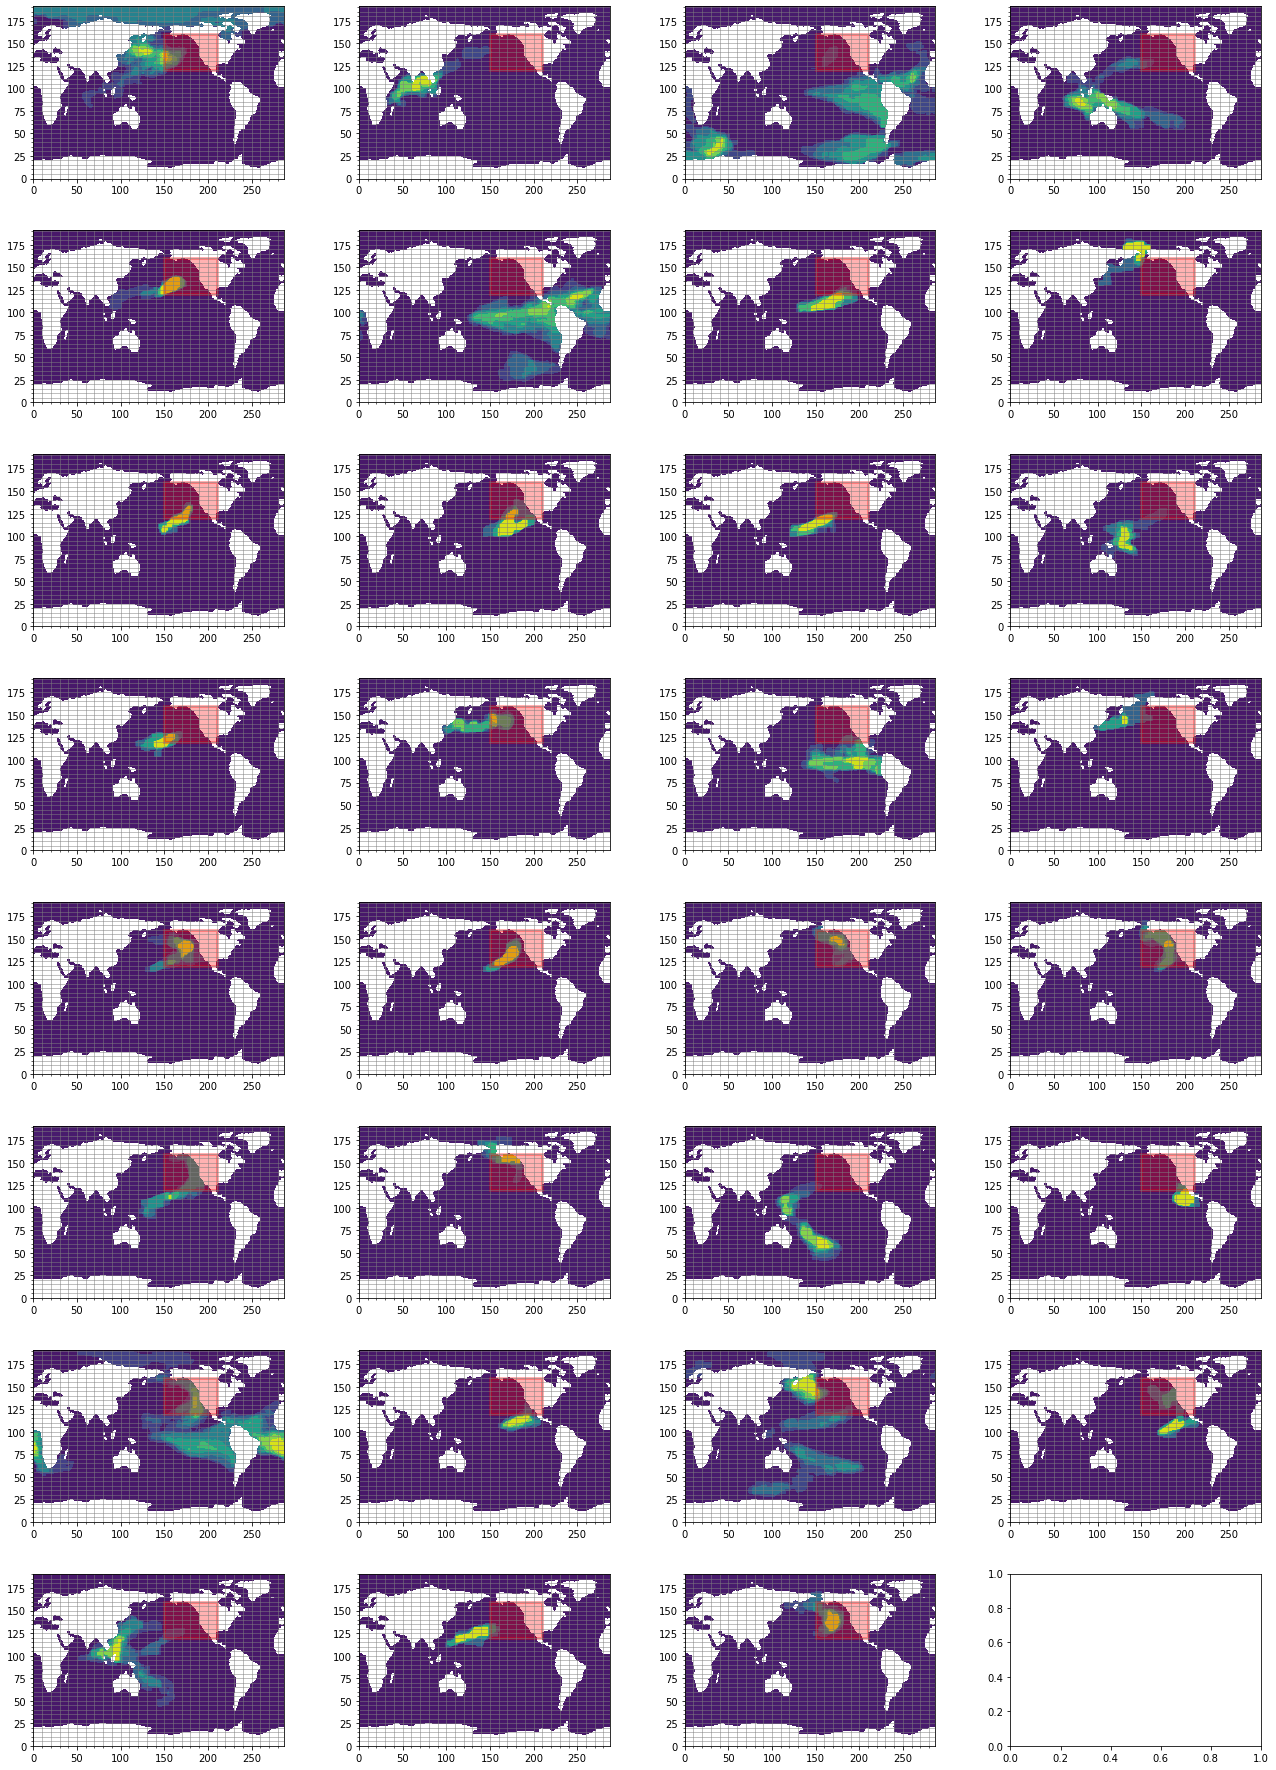

In [79]:
# we will now plot a subset of heatwaves in each category
fig, axs = plt.subplots(8,4, figsize=(22, 32), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3, wspace=.3)
axs = axs.ravel()

for i in range(31):
    axs[i].contourf(density_analysis_arrays[which_ones[i][0]]) # density_analysis_arrays_ones
    axs[i].contourf(land_mask,cmap='binary',vmin=0)
    axs[i].minorticks_on()
    axs[i].grid(which='both', linestyle='-', linewidth='0.5', color='gray')
    loc4 = patches.Rectangle((150, 120), 210-150, 160-120, linewidth=3, edgecolor='r', facecolor='red',alpha=0.3) 
    axs[i].add_patch(loc4)

In [80]:
which_ones_now = np.argwhere(np.asarray(lens_loc4_list)>200) #200

In [81]:
print(len(which_ones_now))
print(which_ones_now)

15
[[  1]
 [  8]
 [ 17]
 [ 39]
 [ 51]
 [ 61]
 [ 63]
 [ 72]
 [ 77]
 [ 78]
 [ 85]
 [104]
 [108]
 [120]
 [138]]


In [ ]:
How do marine heatwaves characteristics cluster in space and time?
-	Intensity, duration, and frequency of positive sea surface temperature anomalies
-	Probability of occurrence
How unusual/extraordinary is the 2014/2015 North Pacific marine heatwave?


In [82]:
from scipy import ndimage

centers_of_masses = []
for i in range(len(which_ones_now)):
    # print(np.nanmax(density_analysis_arrays[which_ones_now[i][0]]))
    # print(ndimage.measurements.center_of_mass(density_analysis_arrays[which_ones_now[i][0]])) # let us find where the center of mass is
    centers_of_masses.append(ndimage.measurements.center_of_mass(density_analysis_arrays[which_ones_now[i][0]]))

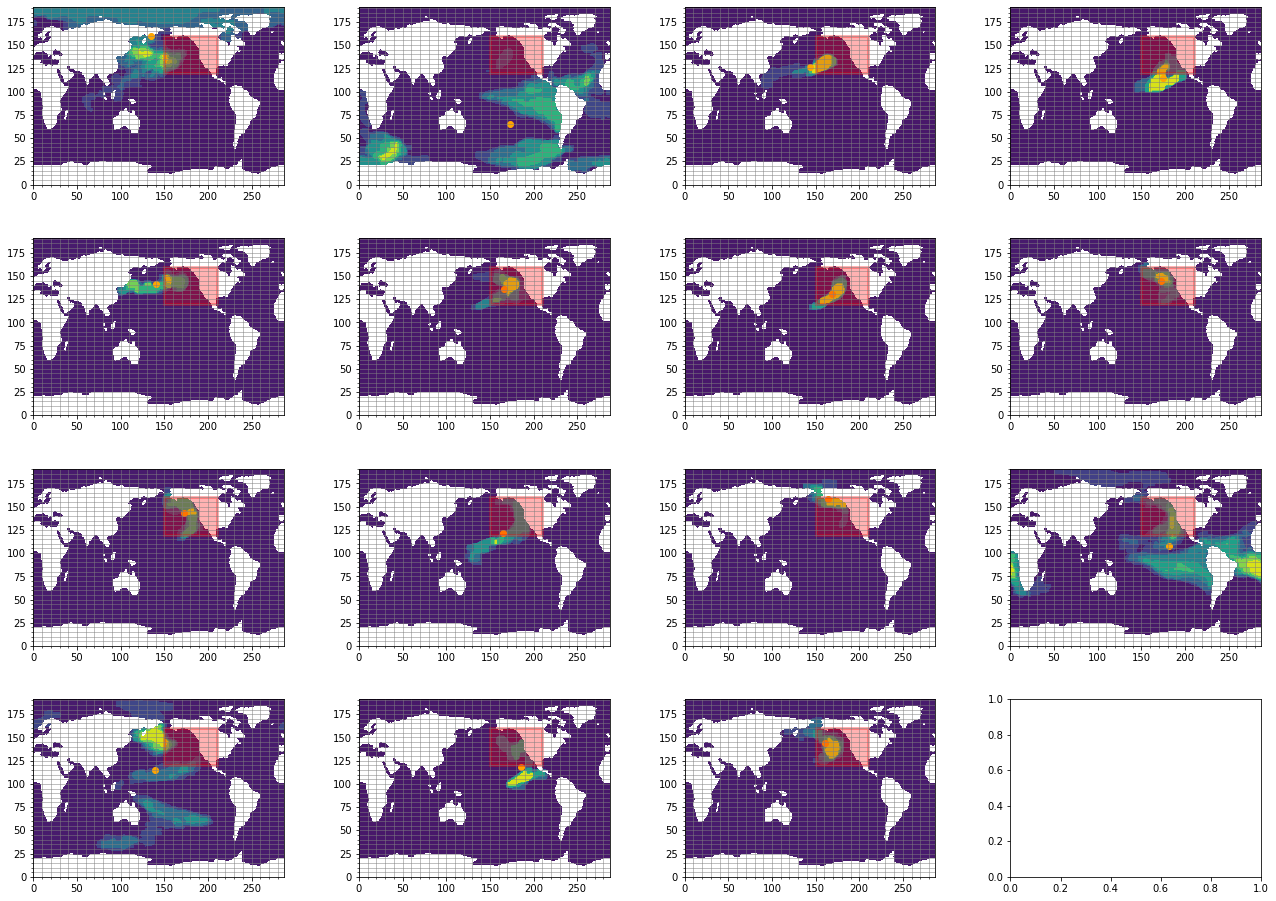

In [83]:
# we will now plot a subset of heatwaves in each category
fig, axs = plt.subplots(4,4, figsize=(22, 16), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3, wspace=.3)
axs = axs.ravel()

for i in range(len(which_ones_now)):
    axs[i].contourf(density_analysis_arrays[which_ones_now[i][0]]) # density_analysis_arrays_ones
    axs[i].contourf(land_mask,cmap='binary',vmin=0)
    axs[i].minorticks_on()
    axs[i].grid(which='both', linestyle='-', linewidth='0.5', color='gray')
    axs[i].scatter(centers_of_masses[i][1],centers_of_masses[i][0], color='orange')
    loc4 = patches.Rectangle((150, 120), 210-150, 160-120, linewidth=3, edgecolor='r', facecolor='red',alpha=0.3) 
    axs[i].add_patch(loc4)

In [84]:
blob_like = []
for i in range(len(which_ones_now)):
    if 150 <= centers_of_masses[i][1] <= 210 and 120 <= centers_of_masses[i][0] <= 160:
        blob_like.append(which_ones_now[i])

In [85]:
print(len(blob_like))

7


In [86]:
density_analysis_arrays[blob_like[6][0]]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

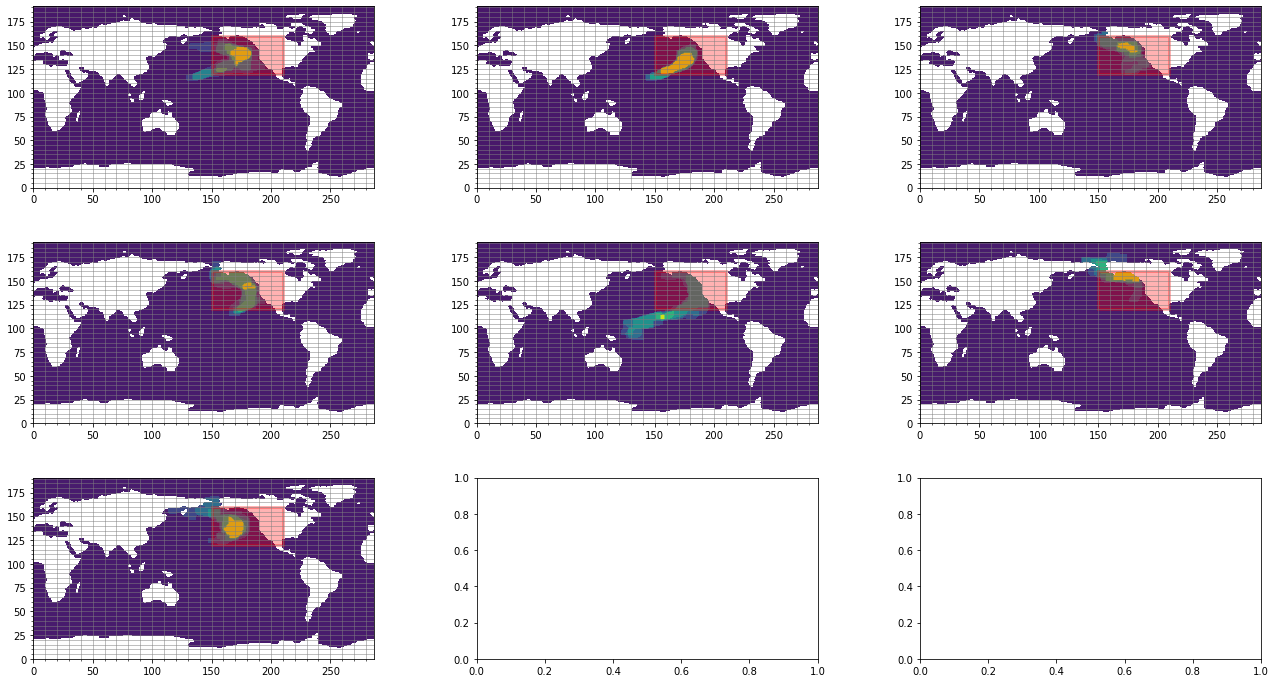

In [87]:
# we will now plot a subset of heatwaves in each category
fig, axs = plt.subplots(3,3, figsize=(22, 12), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3, wspace=.3)
axs = axs.ravel()

for i in range(len(blob_like)):
    axs[i].contourf(density_analysis_arrays[blob_like[i][0]]) # density_analysis_arrays_ones
    axs[i].contourf(land_mask,cmap='binary',vmin=0)
    axs[i].minorticks_on()
    axs[i].grid(which='both', linestyle='-', linewidth='0.5', color='gray')
    loc4 = patches.Rectangle((150, 120), 210-150, 160-120, linewidth=3, edgecolor='r', facecolor='red',alpha=0.3) 
    axs[i].add_patch(loc4)

In [88]:
# Now we look at the timeseries evolution of each of these ones
print(len(density_analysis_arrays))
print(len(i_index))

144
144


In [89]:
# Now we look at the timeseries evolution of each of these ones
print(len(density_analysis_arrays))
print(len(i_index))

# Finding the equivalent marine heatwave in the entire set of heatwaves
time_series_evolution_indices = []
for i in range(len(blob_like)):
    time_series_evolution_indices.append(i_index[blob_like[i][0]])

144
144


In [90]:
off_saved_grids = []
off_saving_time_index = []
for index in range(len(time_series_evolution_indices)):
    grid_to_use = full_use_grids[time_series_evolution_indices[index]]
    temp_saved_grids = []
    saving_time_index_temp = []
    for i in range(481):
        if np.nanmax(grid_to_use[i,:]) == 1.0:
            temp_saved_grids.append(grid_to_use[i,:])
            saving_time_index_temp.append(i)
    off_saved_grids.append(temp_saved_grids)
    off_saving_time_index.append(saving_time_index_temp)

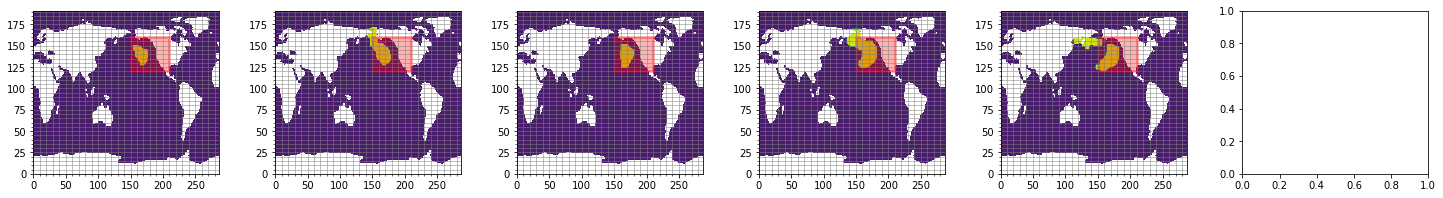

In [99]:
# we will now plot a subset of heatwaves in each category
fig, axs = plt.subplots(1,6, figsize=(25, 3), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3, wspace=.3)
axs = axs.ravel()

which_heatwave = 6
for i in range(len(off_saved_grids[which_heatwave])):
    axs[i].contourf(off_saved_grids[which_heatwave][i]) # density_analysis_arrays_ones
    axs[i].contourf(land_mask,cmap='binary',vmin=0)
    axs[i].minorticks_on()
    axs[i].grid(which='both', linestyle='-', linewidth='0.5', color='gray')
    loc4 = patches.Rectangle((150, 120), 210-150, 160-120, linewidth=3, edgecolor='r', facecolor='red',alpha=0.3) 
    axs[i].add_patch(loc4)

In [92]:
%%time

bloblike_SST_grids = []
true_drop_bloblike_SST_grids = []
for i in range(len(time_series_evolution_indices)): 
    mhw_id = time_series_evolution_indices[i]+1
    mhw_event_rel = member_.where(member_.labels==mhw_id, drop=False)   
    true_drop_mhw_event_rel = member_.where(member_.labels==mhw_id, drop=True)   
    x = mhw_event_rel.SSTA[:,:,:]
    x_true_drop = true_drop_mhw_event_rel.SSTA[:,:,:]
    # no_nans_x = np.nan_to_num(x) # replace all nans with zeroes
    bloblike_SST_grids.append(x) #no_nans_x
    true_drop_bloblike_SST_grids.append(x_true_drop) #no_nans_x

CPU times: user 1.32 s, sys: 1.51 s, total: 2.83 s
Wall time: 2.89 s


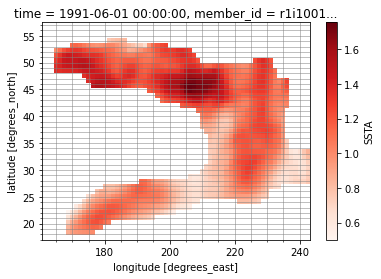

In [107]:
true_drop_bloblike_SST_grids[0][0,:,:].plot(cmap=plt.cm.Reds)
plt.minorticks_on()
plt.grid(which='both', linestyle='-', linewidth='0.5', color='gray')

In [102]:
np.argwhere(np.isfinite(np.asarray(true_drop_bloblike_SST_grids[0][0,:,:]))==True)

array([[ 1,  6],
       [ 1,  7],
       [ 1,  8],
       ...,
       [39, 18],
       [39, 19],
       [39, 20]])

In [104]:
true_drop_bloblike_SST_grids[0][0,:,:].lat[1]
true_drop_bloblike_SST_grids[0][0,:,:].lon[6]

<xarray.DataArray 'lon' ()>
array(168.75)
Coordinates:
    time       object 1991-06-01 00:00:00
    lon        float64 168.8
    member_id  <U11 'r1i1001p1f1'
    quantile   float64 0.9
    month      int64 6
Attributes:
    long_name:  longitude
    units:      degrees_east

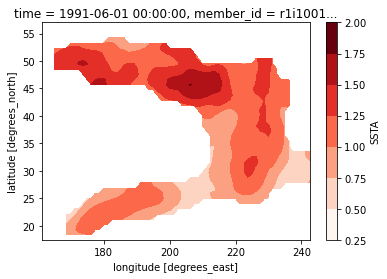

In [91]:
true_drop_bloblike_SST_grids[0][0,:,:].plot.contourf(cmap=plt.cm.Reds)


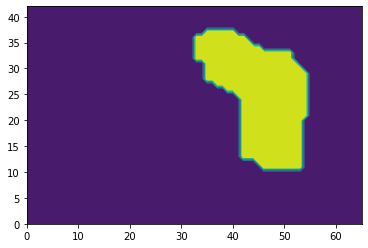

In [94]:
ds = true_drop_bloblike_SST_grids[0][1,:,:]
# lon, lat = np.meshgrid(ds.coords['lon'], ds.coords['lat'])
plt.contourf(ds.notnull())
# lon_masked  = ma.array(lon, mask=dry_areas.airt.fillna(False))
# land_coordinates = zip(lat_masked[lat_masked.mask].data,     lon_masked[lon_masked.mask].data)

In [220]:
np.argwhere(np.array(true_drop_bloblike_SST_grids[0][1,:,:].values)==True)

array([], shape=(0, 2), dtype=int64)

In [96]:
# https://stackoverflow.com/questions/64053424/python-xarray-index-return
len(np.argwhere(true_drop_bloblike_SST_grids[0][0,:,:].where(true_drop_bloblike_SST_grids[0][1,:,:] > 0,0).values))

368

In [80]:
np.argwhere(true_drop_bloblike_SST_grids[0][1,:,:].where(true_drop_bloblike_SST_grids[0][1,:,:] < 0.0).values)

array([], shape=(0, 2), dtype=int64)

In [189]:
off_saved_grids = []
off_saving_time_index = []
for index in range(len(bloblike_SST_grids)):
    grid_to_use = bloblike_SST_grids[index]
    true_drop_grid_to_use = true_drop_bloblike_SST_grids[index]
    
    temp_saved_grids = []
    saving_time_index_temp = []
    for i in range(481):
        if np.nanmax(grid_to_use[i,:]) > 0.0:
            temp_saved_grids.append(grid_to_use[i,:])
            saving_time_index_temp.append(i)
    off_saved_grids.append(temp_saved_grids)
    off_saving_time_index.append(saving_time_index_temp)

/glade/scratch/cassiacai/ipykernel_155199/2217110796.py:10: RuntimeWarning: All-NaN axis encountered
  if np.nanmax(grid_to_use[i,:]) > 0.0:


In [186]:
off_saved_grids[0][0].lat.values

array([-90.        , -89.05759162, -88.11518325, -87.17277487,
       -86.23036649, -85.28795812, -84.34554974, -83.40314136,
       -82.46073298, -81.51832461, -80.57591623, -79.63350785,
       -78.69109948, -77.7486911 , -76.80628272, -75.86387435,
       -74.92146597, -73.97905759, -73.03664921, -72.09424084,
       -71.15183246, -70.20942408, -69.26701571, -68.32460733,
       -67.38219895, -66.43979058, -65.4973822 , -64.55497382,
       -63.61256545, -62.67015707, -61.72774869, -60.78534031,
       -59.84293194, -58.90052356, -57.95811518, -57.01570681,
       -56.07329843, -55.13089005, -54.18848168, -53.2460733 ,
       -52.30366492, -51.36125654, -50.41884817, -49.47643979,
       -48.53403141, -47.59162304, -46.64921466, -45.70680628,
       -44.76439791, -43.82198953, -42.87958115, -41.93717277,
       -40.9947644 , -40.05235602, -39.10994764, -38.16753927,
       -37.22513089, -36.28272251, -35.34031414, -34.39790576,
       -33.45549738, -32.51308901, -31.57068063, -30.62

In [ ]:
coords = list(zip(lat, lon)); temp_coords.append(coords)
temp_lat.append(lat); temp_lon.append(lon)
y,x=zip(*coords)
dlon = [np.cos(y[c]*np.pi/180)*(111.320*1) for c in np.arange(0, len(coords))]
dlat = (110.574 *1) * np.ones(len(dlon))
cell_area = [np.sum(dlon[c]*dlat[c]) for c in np.arange(0, len(coords))]; temp_cell_area.append(np.sum(cell_area))

In [ ]:
coords_ls.append(temp_coords)
cell_area_ls.append(temp_cell_area)
lat_ls.append(temp_lat)
lon_ls.append(temp_lon)

In [175]:
intense_mean = []
intense_max = []
intense_min = []
intense_cumu = []

for i in range(len(off_saved_grids)):
    intense_mean_temp = []
    intense_max_temp = []
    intense_min_temp = []
    intense_cumu_temp = []
    for timestep in range(len(off_saved_grids[i])):
        intense_max_temp.append(np.nanmax(off_saved_grids[i][timestep]))
        intense_mean_temp.append(np.nanmean(off_saved_grids[i][timestep]))
        intense_min_temp.append(np.nanmin(off_saved_grids[i][timestep]))
        intense_cumu_temp.append(np.nansum(off_saved_grids[i][timestep]))
    intense_mean.append(intense_mean_temp)
    intense_max.append(intense_max_temp)
    intense_min.append(intense_min_temp)
    intense_cumu.append(intense_cumu_temp)

1.7540597477945425
1.094728048630164
0.49973308211190215
__
1.4986416555088908
1.1346473930730234
0.6800668072494886
__
1.8859472709214629
1.158981230547711
0.41042565259704133
__
1.8038387324601786
1.163600866292209
0.45749342211530575
__
***
1.8751817099358163
1.0457056116679708
0.5250043227797505
__
1.8236419964418928
1.001693833068655
0.3735990435024519
__
1.4055549085411485
1.055945290689344
0.5205191964540177
__
***
1.7856054080440344
0.9809804370191304
0.43139017822954884
__
2.263604336426397
1.3843030913679193
0.0
__
2.0369361848226504
1.156839333914056
0.0
__
1.6744383957953914
1.022259419031973
0.5918471152976963
__
1.073766389600621
0.8019403003719044
0.4536619296450226
__
***
1.9617450900687459
1.085211182266996
0.0
__
2.7151551785319725
1.4155897977118037
0.0
__
3.4034022858819526
1.449870591101145
0.0
__
2.1108130137376406
1.1306977860804308
0.0
__
1.5086928972289684
1.0370183922290117
0.6087889099236463
__
2.00680745896517
1.1140525000156438
0.49640732435142354
__
***
1.

In [176]:
len(off_saved_grids)

7

In [177]:
print(len(off_saved_grids[0]))

4


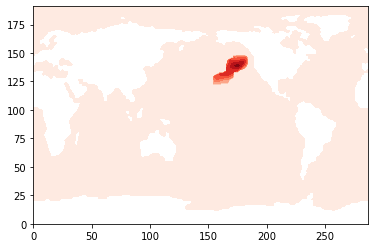

In [164]:
plt.contourf(off_saved_grids[0][3], cmap='Reds')
plt.contourf(land_mask,cmap='binary',vmin=0)
plt.show()

In [ ]:
# 
# SST values which ones are particularly strong even if they're short # where the max. temp. is at each timestep --> types --> reach the coast


In [ ]:
off_saving_time_index

In [ ]:
for i in range(len(time_series_evolution_indices)):
    print(time_series_evolution_indices[i])

In [ ]:
no149 = member_.where(member_.labels==149, drop=False) 


In [ ]:
no149.SSTA[:,:,:]

In [ ]:
time_series_evolution_indices

In [ ]:
# size
# 

In [ ]:
len(off_saved_grids[0])

In [ ]:
full_use_grids[149].shape

In [ ]:
plt.contourf(full_use_grids[149].sum(axis=(0)))

In [ ]:
# -- timeseries of the interesting ones
# -- maybe change some of the regional boxes (where their edges are)
# -- pipeline for the other ensemble members (so how many blob-like ones in each?)
    # -- statistics --> cumulative intensity --> maximum intensity as a function of time --> temperature x area over time
# -- working hypothesis: the blob is not an unprecedented event. We can expect to see it. How often? How common? Variability? Explore some metrics.


In [ ]:
%%time
# ---------------------------------------
# Note that this uses a lot of memory
# This takes a little more than 3 minutes
# ---------------------------------------
full_use_grids = []

for i in range(1,ending_val): 
    mhw_id = i
    mhw_event_rel = member_.where(member_.labels==mhw_id, drop=False)   # dimensions are (481, 192, 288) --> (time, lat, lon)
    x = mhw_event_rel.SSTA[:,:,:]
    no_nans_x = np.nan_to_num(x) # replace all nans with zeroes
    no_nans_x[no_nans_x != 0] = 1 # replace all SSTA values with 1 (for shape comparison)
    full_use_grids.append(no_nans_x)

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
kmeans.labels_

In [ ]:
A = ['first', 'second', 'third']
B = ['first', 'forth']
C = ['second', 'third']
D = ['first', 'third']
E = ['first', 'fifth']
F = ['fourth', 'fifth']

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
l = [' '.join(i) for i in [A,B,C,D,E,F]]
vec = CountVectorizer(analyzer='word', ngram_range=(1,1))

X = distance_matrix
.astype(int)

In [ ]:
len(X)

In [ ]:
model = lda.LDA(n_topics=5, random_state=1)
model.fit(X)

In [ ]:
print(len(doc_topic))

In [ ]:
doc_topic = model.doc_topic_

clustering_result_list = []
for i in range(len(X)):
    clustering_result_list.append(doc_topic[i].argmax())
    # print(f'Cluster {i}: Topic ', doc_topic[i].argmax())

In [ ]:
clustering_result_array = np.asarray(clustering_result_list)
clustering_result_array

In [ ]:
zeros = np.where(np.asarray(clustering_result_array) == 0)
zeros

In [ ]:
ones = np.where(np.asarray(clustering_result_array) == 1)
ones

In [ ]:
twos = np.where(np.asarray(clustering_result_array) == 2)
twos

In [ ]:
threes = np.where(np.asarray(clustering_result_array) == 3)
threes

In [ ]:
fours = np.where(np.asarray(clustering_result_array) == 4)
fours

In [ ]:
plt.contourf(winter_long_arrays_ones[0])
plt.show()
plt.contourf(winter_long_arrays_ones[4])
plt.show()
plt.contourf(winter_long_arrays_ones[5])
plt.show()

In [ ]:
# dynamic time warping
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

# d = {} # dictionary figure this out (how to index)
distances_i = []
for i in range(len(sortedRegions_list)):
    distance_j = []
    for j in range(len(sortedRegions_list)):
        distance, path = fastdtw(sortedRegions_list[i], sortedRegions_list[j], dist=euclidean)
        # d[(i, j)] = distance
        distance_j.append(distance)
    distances_i.append(distance_j)

In [ ]:
distance_matrix = np.array(distances_i)
X = distance_matrix

In [ ]:
from sklearn.manifold import SpectralEmbedding

embedding = SpectralEmbedding(n_components=2, affinity='precomputed')
X_transformed = embedding.fit_transform(X)
X_transformed.shape

In [ ]:
x_axis = X_transformed[:,0]
y_axis = X_transformed[:,1]

In [ ]:
from sklearn.cluster import SpectralClustering

In [ ]:
clustering = SpectralClustering(n_clusters=16, assign_labels='discretize', affinity='precomputed', random_state=0).fit(distance_matrix)

In [ ]:
annotations=np.arange(0,14)

plt.scatter(x_axis, y_axis, c=clustering.labels_)
for i, label in enumerate(annotations):
    plt.annotate(label, (x_axis[i], y_axis[i]))
plt.show()

In [ ]:
clustering.labels_

In [ ]:
plt.contourf(winter_long_arrays_ones[2])
plt.show()
plt.contourf(winter_long_arrays_ones[5])
plt.show()

In [ ]:
# metrics
lens_weighting_list = [len(l) for l in weighting_list] 
one = np.where(np.asarray(lens_weighting_list) == 1)
one

In [ ]:
weighting_list[5]
region_num_list[5]
plt.contourf(winter_long_arrays_ones[5])

In [ ]:
weighting_list[10]
region_num_list[10]
plt.contourf(winter_long_arrays_ones[10])

In [ ]:
print(weighting_list[29])
print(region_num_list[29])
plt.contourf(winter_long_arrays_ones[29])

In [ ]:
print(weighting_list[46])
print(region_num_list[46])

In [ ]:
print(weighting_list[2])
print(region_num_list[2])

In [ ]:
primary_region = [item[0] for item in sortedRegions_list]
np.asarray(primary_region)

In [ ]:
result = np.where(np.asarray(primary_region) == 12)
result

In [ ]:
# let's check 
plt.contourf(winter_long_arrays_ones[0])
plt.show()
plt.contourf(winter_long_arrays_ones[4])
plt.show()
plt.contourf(winter_long_arrays_ones[21])
plt.show()
plt.contourf(winter_long_arrays_ones[31])
plt.show()
plt.contourf(winter_long_arrays_ones[46])
plt.show()
plt.contourf(winter_long_arrays_ones[58])
plt.show()
plt.contourf(winter_long_arrays_ones[60])
plt.show()
plt.contourf(winter_long_arrays_ones[62])
plt.show()

In [ ]:
# let's check 
plt.contourf(winter_long_arrays_ones[4])

In [ ]:
print(weighting_list[0])
print(region_num_list[0])

In [ ]:
inds = np.array(region_sizes)
inds = np.argsort(-inds)
region_sizes = [len(loc_1_combinations), len(loc_2_combinations), len(loc_3_combinations), len(loc_4_combinations),
               len(loc_5_combinations), len(loc_6_combinations), len(loc_7_combinations), len(loc_8a_combinations) + len(loc_8b_combinations),
               len(loc_9_combinations), len(loc_10_combinations), len(loc_11_combinations), len(loc_12_combinations),
               len(loc_13_combinations), len(loc_14_combinations), len(loc_15_combinations), len(loc_16_combinations)]
sorted_region_sizes = np.array(region_sizes)[inds]

inds_sorted_region_sizes = inds + 1
np.asarray(inds_sorted_region_sizes)

In [ ]:
sorted_region_sizes / 10000 # weighting by region box size 

In [ ]:
# metrics of similarity --> check image processing --> distance
# area versus perimeter score, come up with different metrics

In [ ]:
plt.contourf(winter_long_arrays_ones[7])

In [ ]:
plt.contourf(winter_long_arrays_ones[10])

In [ ]:
plt.contourf(winter_long_arrays_ones[4])

In [ ]:
plt.contourf(winter_long_arrays_ones[2])

In [ ]:
plt.contourf(winter_long_arrays_ones[7])

In [ ]:
df_locations['Sum'] = df_locations['loc1'] + df_locations['loc2'] + df_locations['loc3'] + df_locations['loc4'] + df_locations['loc5'] + df_locations['loc6'] + df_locations['loc7'] + df_locations['loc8'] + df_locations['loc9'] + df_locations['loc10'] + df_locations['loc11'] + df_locations['loc12'] + df_locations['loc13'] + df_locations['loc14'] + df_locations['loc15'] + df_locations['loc16']
df_locations = df_locations.sort_values(by=['Sum'])
df_locations = df_locations.reset_index()
df_locations

In [ ]:
# weighting decision
print()


In [ ]:
list(df_locations['non_zero'])

# Other work

In [ ]:
# https://stackoverflow.com/questions/71390379/cosine-similarity-matrix-for-2d-array
a.flatten()
b.flatten()

In [ ]:
from math import dist

dist(a.flatten(), b.flatten())

In [ ]:
new = np.linalg.norm(a, axis=1, keepdims=True)
print(len(np.asarray(new)))

# np.linalg.norm(b, axis=1, keepdims=True)

In [ ]:
# taking into consideration size
# take into consideration location
# some way to standardize

plt.figure(figsize=(5,4))
plt.contourf(summer_long_arrays_ones[3])
plt.show()

plt.figure(figsize=(5,4))
plt.contourf(summer_long_arrays_ones[8])
plt.show()

In [ ]:
plt.figure(figsize=(5,4))
plt.contourf(summer_long_arrays_ones[3] - summer_long_arrays_ones[8], cmap='seismic')
plt.colorbar()
plt.show()

plt.figure(figsize=(5,4))
plt.contourf(summer_long_arrays_ones[3] - summer_long_arrays_ones[0], cmap='seismic')
plt.colorbar()
plt.show()


plt.figure(figsize=(5,4))
plt.contourf(summer_long_arrays_ones[3] - summer_long_arrays_ones[1], cmap='seismic')
plt.colorbar()
plt.show()

In [ ]:
a =summer_long_arrays_ones[3]
b = summer_long_arrays_ones[8]
dist = np.linalg.norm(a-b)
print(dist)

In [ ]:
a =summer_long_arrays_ones[3]
b = summer_long_arrays_ones[0]
dist = np.linalg.norm(a-b)
print(dist)

In [ ]:
len(winter_long_arrays_ones)

In [ ]:
dist = numpy.linalg.norm(a-b)

<code style="background:navy;color:white"> Using sklearn </code>

In [ ]:
# using sklearn

# ---
# Pointer: sklearn has functionalities for PCA and Ridge regression with crossvalidation.
# Using these can make your life much easier.
# ---

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [ ]:
array_in_question = winter_long_arrays #winter_long_arrays_ones
winter_long_arrays_as_array =np.array([np.array(xi) for xi in array_in_question])
winter_long_arrays_as_array_reshaped = np.reshape(winter_long_arrays_as_array, [64, 192*288])
print(winter_long_arrays_as_array.shape)
print(winter_long_arrays_as_array_reshaped.shape)

In [ ]:
X_train = winter_long_arrays_as_array_reshaped # just a simple rename step

In [ ]:
mean_data = np.mean(X_train,0)
centered_X_train = X_train - mean_data

X_train_standard = StandardScaler().fit_transform(centered_X_train)

pca = PCA(n_components = 0.95) # 95 percent
pca.fit(X_train_standard)

In [ ]:
components = pca.components_
print(components.shape)

In [ ]:
#### Explained variance, explained variance ratio, singular values
# -------------------------------------------
# From documentation:

# explained_variance_ : array, shape (n_components,) The amount 
# of variance explained by each of the selected components.

# explained_variance_ratio_ : array, shape (n_components,) Percentage 
# of variance explained by each of the selected components.

# singular_values_ndarray of shape (n_components,)
# The singular values corresponding to each of the selected components. 
# The singular values are equal to the 2-norms of the n_components 
# variables in the lower-dimensional space.

# -------------------------------------------

nuclear_norm = np.linalg.norm(pca.singular_values_) # is the sum of singular singulars
sv_scaled = pca.singular_values_**2/(nuclear_norm**2) 
# sv_scaled = pca.explained_variance_ratio_
sv_total = np.cumsum(pca.singular_values_**2)/(nuclear_norm**2)

In [ ]:
# -- Plot the singular values
plt.rcParams["figure.figsize"] = (28,6)

plt.subplot(1, 4, 1)
plt.plot(sv_scaled, 'blue') # equivalent to pca.explained_variance_ratio_
plt.xticks(fontsize=15); plt.yticks(fontsize=15)
plt.xlabel('PCA component', fontsize=15)
plt.ylabel('explained variance ratio', fontsize=15)
plt.ylim(0,0.25)

plt.subplot(1, 4, 2)
plt.plot(sv_total, 'blue')
plt.xticks(fontsize=15); plt.yticks(fontsize=15)
plt.axhline(y=0.60,color='black',linestyle = '--',c='gold')
plt.axhline(y=0.80,color='black',linestyle = '--', c='orange')
plt.axhline(y=0.90,color='black',linestyle = '--',c='red')
plt.xlabel('PCA component', fontsize=15)
plt.ylabel('cumulatiave explained variance ratio', fontsize=15)
plt.ylim(0.2,1.02)

plt.subplot(1, 4, 3)
plt.plot(sv_total[:30], 'blue')
plt.xticks(fontsize=15); plt.yticks(fontsize=15)
plt.axhline(y=0.60,color='black',linestyle = '--',c='gold')
plt.axhline(y=0.80,color='black',linestyle = '--', c='orange')
plt.axhline(y=0.90,color='black',linestyle = '--',c='red')
plt.xlabel('PCA component', fontsize=15)
plt.ylabel('cumulatiave explained variance ratio', fontsize=15)
plt.ylim(0.2,1.02)

plt.subplot(1, 4, 4)
plt.plot(np.log(sv_scaled),'blue') # equivalent to np.log(pca.singular_values_)
plt.xticks(fontsize=15); plt.yticks(fontsize=15)
plt.xlabel('PCA component', fontsize=15)
plt.ylabel('log(explained variance ratio)', fontsize=15)
plt.ylim(-5.6,-1.4)

plt.show()

In [ ]:
# How many PCA modes do you need to keep in order to approximate X_train up to 60%, 80% 90% and 95% in the Frobenius norm?
pca = PCA((.6)**2)
pca.fit(X_train_standard)
components = pca.components_
print(components.shape)

pca = PCA((.8)**2)
pca.fit(X_train_standard)
components = pca.components_
print(components.shape)

pca = PCA((.9)**2)
pca.fit(X_train_standard)
components = pca.components_
print(components.shape)

pca = PCA((.95)**2)
pca.fit(X_train_standard)
components = pca.components_
print(components.shape)

In [ ]:
pca = PCA(n_components = 23)
pca.fit(X_train_standard)

scores_pca = pca.transform(X_train_standard)

In [ ]:
# We fit K means using the transformed data from the PCA
wcss = []
for i in range(1, 21):
    kmeans_pca = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

In [ ]:
# plotting the WCSS against the number of components on a graph
plt.figure(figsize=(8,6))
plt.plot(range(1,21), wcss, marker = 'o', linestyle = '--')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('K-means with PCA Clustering')
plt.show()

In [ ]:
kmeans_pca = KMeans(n_clusters = 13, init='k-means++', random_state = 42)

In [ ]:
kmeans_pca.fit(scores_pca)

In [ ]:
df_pca_kmeans = pd.DataFrame(scores_pca)
df_pca_kmeans['K-Means PCA'] = kmeans_pca.labels_
df_pca_kmeans.head()

In [ ]:
kmeans_pca.labels_

In [ ]:
plt.figure(figsize=(8,6))
plt.contourf(array_in_question[0])
plt.show()

plt.figure(figsize=(8,6))
plt.contourf(array_in_question[2])
plt.show()

plt.figure(figsize=(8,6))
plt.contourf(array_in_question[3])
plt.show()

plt.figure(figsize=(8,6))
plt.contourf(array_in_question[4])
plt.show()

In [ ]:
df_pca_kmeans['Segment'] = df_pca_kmeans['K-Means PCA'].map({0:'first',
                                                            1:'second',
                                                            2:'third',
                                                            3:'fourth',
                                                            4:'fifth',
                                                            5:'sixth',
                                                            6:'seventh',
                                                            7:'eighth',
                                                            8:'ninth',
                                                            9:'tenth',
                                                            10:'eleventh',
                                                            11:'twelth',
                                                            12:'thirteenth'})

In [ ]:
import seaborn as sns 

x_axis=df_pca_kmeans.iloc[:, 1]
y_axis=df_pca_kmeans.iloc[:, 0]
plt.figure(figsize=(10,8))
sns.scatterplot(x_axis, y_axis, hue=df_pca_kmeans['Segment'])
plt.title('Cluster by PCA components')
plt.show()

In [ ]:
plt.scatter(components[0], components[1], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

plt.scatter(components[2], components[3], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

<code style="background:navy;color:white"> Spectral clustering </code>
<code> : Referencing code completed for AMATH 582 Homework 4 Classifying Politicians </code>

In [ ]:
import scipy as sp
from sklearn.linear_model import Ridge
import scipy.spatial

In [ ]:
# define a weight function
def eta(t, l):
    val = np.exp(-(1/(2*l**2))*t**2 )
    return val

In [ ]:
# ----- define function to construct unnnomarlized graph Laplacian on features
def construct_graph_Laplacian(dist, l):
# -----------------------------------
# l is a hyperparameter of the Gaussian width
# alternatively, can be defined as: l = 0.05*dist.mean() # l length scale of the kernel...also hyperparameter of Guassian width
    W = eta(dist, l)
    d = np.sum(W, axis=1) # degree vector
    D = np.diag(d)
    graph_Laplacian = D - W # unnormalized graph Laplacian
    return graph_Laplacian

In [ ]:
dist = sp.spatial.distance_matrix( X_train, X_train)

plt.imshow(dist)
plt.colorbar()
plt.show()

In [ ]:
graph_Laplacian = construct_graph_Laplacian(dist, 500) # defined 

ll, VV = np.linalg.eigh(graph_Laplacian) # compute eigendecompositions 
idx = ll.argsort() # we need to sort the eigenvalues and vectors 
l = ll[idx]
V = VV[:, idx]

fiedler_vector = V[:,1]

In [ ]:
plt.imshow(graph_Laplacian)
plt.show()

In [ ]:
def plot_digits(XX, N):
    """Small helper function to plot N**2 digits."""
    fig, ax = plt.subplots(N, N, figsize=(12, 8))
    fig.subplots_adjust(hspace = .3, wspace=.1)
    for i in range(N):
        for j in range(N):
            im = ax[i,j].contourf(XX[(N)*i+j,:].reshape((192, 288)), cmap="binary")
            ax[i,j].axis("on")

In [ ]:
## --------------------------------------- plotting all long mhws in the fall
# fig, axs = plt.subplots(16,4, figsize=(18, 72), facecolor='w', edgecolor='k')
# fig.subplots_adjust(hspace = .3, wspace=.1)
# axs = axs.ravel()

# for i in range(len(fall_long_arrays)):
#     axs[i].contourf(fall_long_arrays[i], cmap='gist_heat_r')
#     axs[i].contourf(land_mask,cmap='binary_r',vmin=0)

In [ ]:
plot_digits(components[:16,:], 4)

In [ ]:
plt.contourf(fall_long_arrays[0],cmap='gist_heat_r')

### Timeseries clustering

In [ ]:
# dynamic time warping
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

In [ ]:
latitudes = ensemble0_events["t_lats"]
longitudes = ensemble0_events["t_lons"]

In [ ]:
coord = []

for a, b in zip( list(longitudes[0][0]), list(latitudes[0][0]) ):
    coord.append( [ a, b ] )

In [ ]:
plt.scatter(longitudes[369],latitudes[369])

In [ ]:
# clustering on timeseries symmetry

In [ ]:
# footprint
# northwest Atlantic

In [ ]:
row_1=ensemble0_events.iloc[0]

In [ ]:
row_1

In [ ]:
variable_call = 't_max_SSTA'
row_1.variable_call
# xAxis = np.arange(0, len(row_1.t_max_SSTA))

# plt.plot(xAxis, row_1.t_max_SSTA)
# plt.plot(xAxis, row_1.t_mean_SSTA, c='red')
# plt.plot(xAxis, row_1.t_min_SSTA)

In [ ]:
row_1.t_sum_SSTA

In [ ]:
len(row_1.t_lats)

In [ ]:
plt.scatter(row_1.t_lats[0], row_1.t_lons[0])

In [ ]:
plt.scatter(row_1.t_lats[1], row_1.t_lons[1])

In [ ]:
# remove all short heatwaves and replot the figure below
# take the whole timeseries and remove ENSO --> take Nino3.4 index
# regress that out of SST fields? --> do this by season (separately)
# looking for some advice remove ENSO impacts both in the tropics and teleconnections to extratropics --> SST fields 
# ask (Young-oh)